# Calibrate the holograms using Halpha filter
==================================================================================================

- author : Jérémy Neveu
- date   : May 31st 2017


In [3]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

print theNotebook
from IPython.display import Image, display
import sys
sys.path.append("../../common_tools/")
from common_notebook import *

init_notebook()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
FindCentralStar
ccdproc version 1.2.0
bottleneck version 1.2.0
/Users/jneveu/Documents/LSST/Calibration/CTIOAnaJun2017/ana_31may17/FocusHalpha


### Input directory

In [5]:
inputdir="../OverScanRemove/trim_images"
MIN_IMGNUMBER=51
MAX_IMGNUMBER=55
object_name='HD111980'
SelectTagRe='^trim_20170531_([0-9]+).fits$' # regular expression to select the file
SearchTagRe='^trim_20170531_[0-9]+.fits$'
NBIMGPERLROW=4

### Output directories

In [6]:
dir_top_images="images_notebooks/"+theNotebook ### Top directory to save images
ensure_dir(dir_top_images) # create that directory

outputdir="./cut_fitsimages"
ensure_dir(outputdir)

## Location of the spectra
----------------------------------

In [7]:
dirlist_all = [inputdir]
sorted_numbers,sorted_files = MakeFileList(dirlist_all,MIN_IMGNUMBER,MAX_IMGNUMBER,SelectTagRe,SearchTagRe) 

all_dates,all_airmass,all_images,all_titles,all_header,all_expo,all_filt=BuildImages(sorted_files,sorted_numbers,object_name)

print 'Number of images:',len(all_images)

Number of images: 5


### Show images

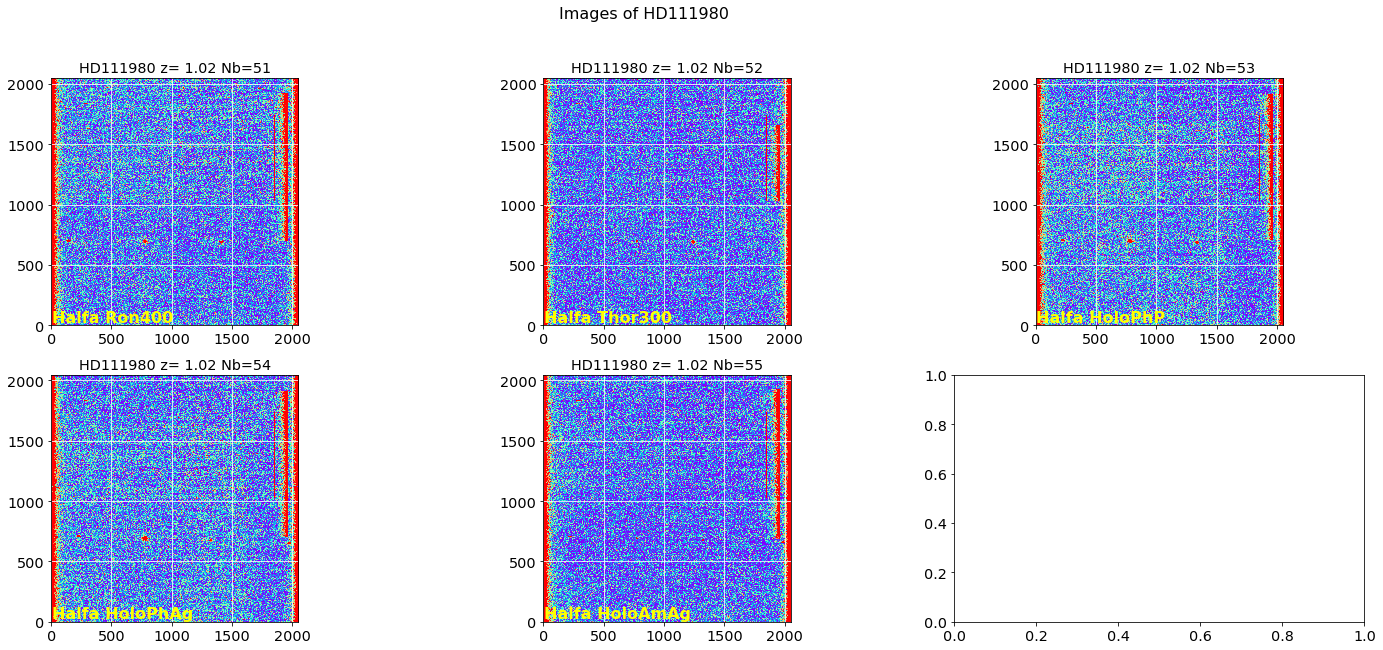

In [8]:
ShowImages(all_images,all_titles,all_filt,object_name,NBIMGPERLROW=3,vmin=0,vmax=20)

figfilename=os.path.join(dir_top_images,'input_images.pdf')
plt.savefig(figfilename)   

### Show histograms

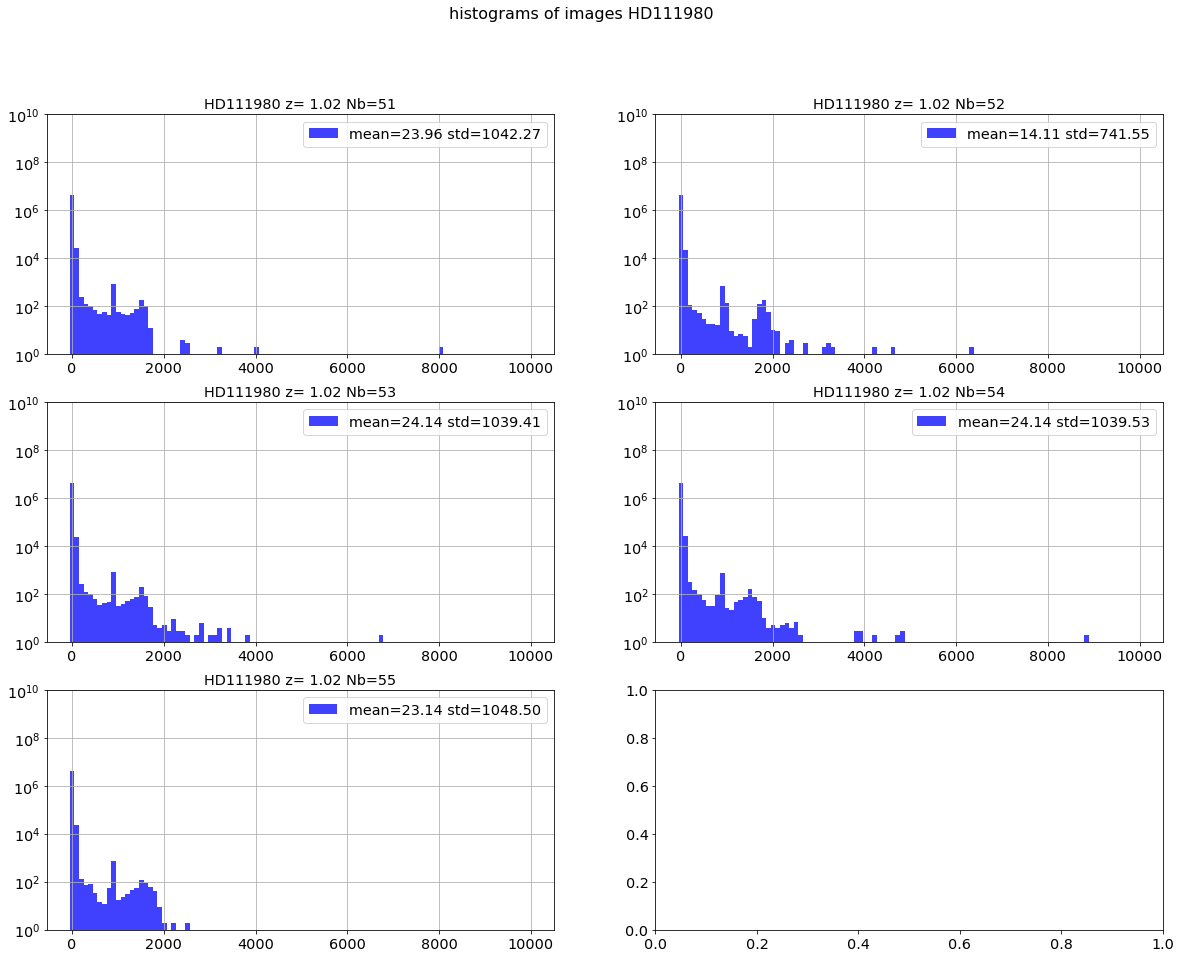

In [9]:
ShowHistograms(all_images,all_titles,all_filt,object_name,NBIMGPERLROW=2,bins=100,range=(-50,10000))

### Cut the images

To extract the spectra to analyze

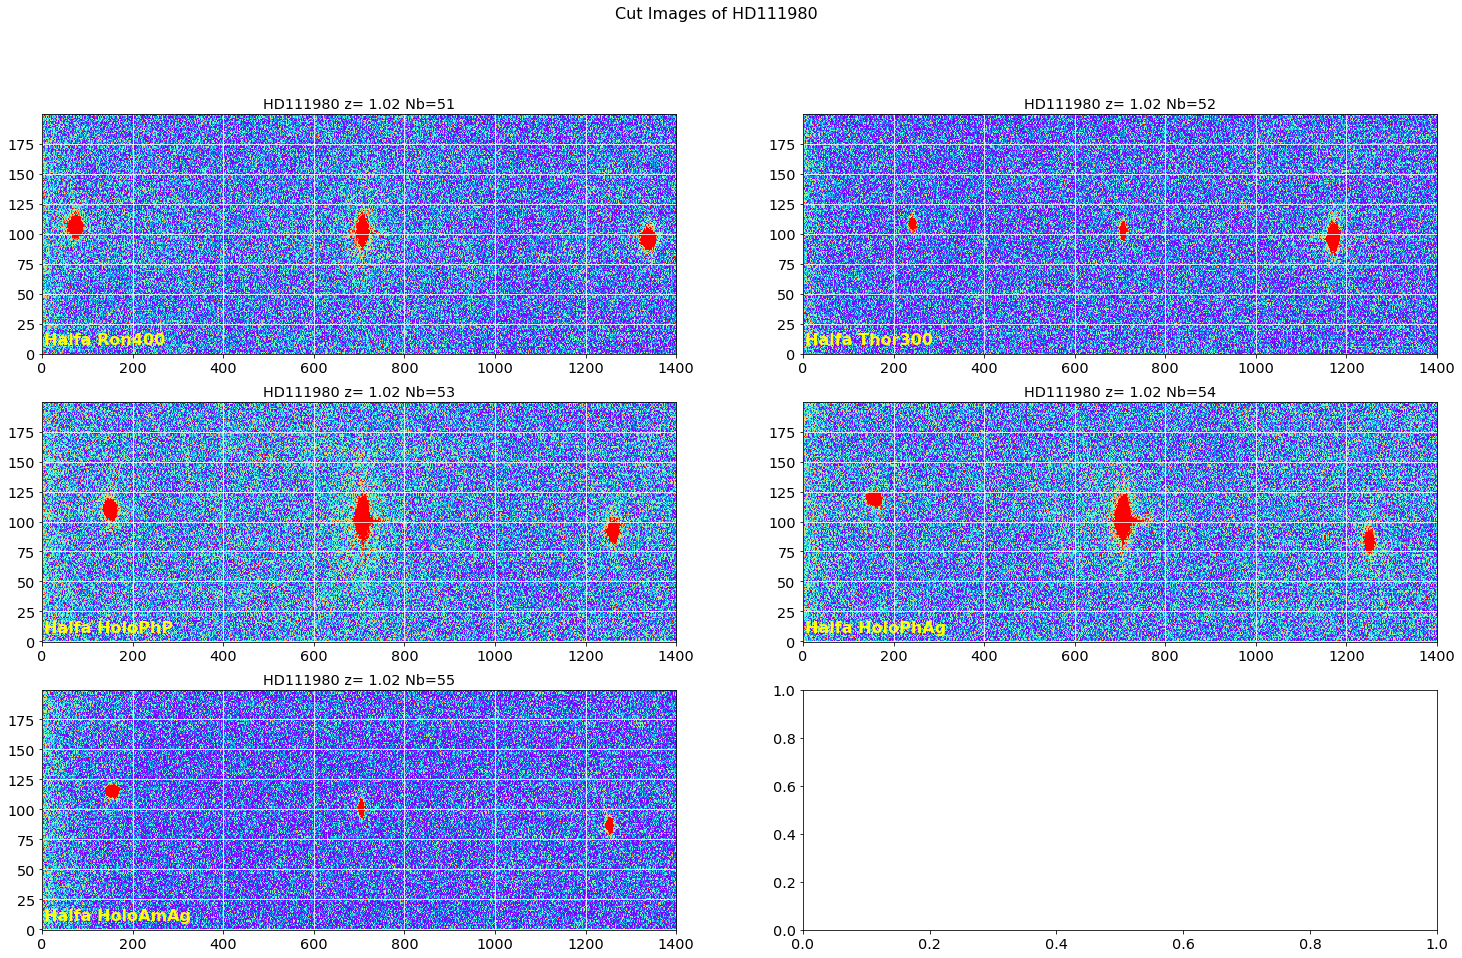

In [10]:
x_guess = [770]*len(all_images)
y_guess = [690]*len(all_images)
DeltaY=[100]*len(all_images)
DeltaX=[700]*len(all_images)

images_cut=ShowCenterImages(x_guess,y_guess,DeltaX,DeltaY,all_images,all_titles,all_filt,object_name,NBIMGPERLROW=2,vmin=0,vmax=20)
figfilename=os.path.join(dir_top_images,'cut_images.pdf')
plt.savefig(figfilename)   

### Save cut images

In [11]:
newfullfilenames=[]
for idx,file in np.ndenumerate(sorted_files):
    short_infilename=file.split("/")[3]
    print short_infilename
    short_partfilename=re.findall('^trim_(.*)',short_infilename)
    short_outfilename='cutimg_'+short_partfilename[0]
    newfullfilename=os.path.join(outputdir,short_outfilename)
    newfullfilenames.append(newfullfilename)
    
for idx,file in np.ndenumerate(newfullfilenames):
    prihdu = fits.PrimaryHDU(header=all_header[idx[0]],data=images_cut[idx[0]])
    thdulist = fits.HDUList(prihdu)
    thdulist.writeto(file,overwrite=True)

trim_20170531_051.fits
trim_20170531_052.fits
trim_20170531_053.fits
trim_20170531_054.fits
trim_20170531_055.fits


In [12]:
!ls -l cut_fitsimages/*

-rw-r--r--  1 jneveu  staff  2252160  7 aoû 14:23 cut_fitsimages/cutimg_20170531_051.fits
-rw-r--r--  1 jneveu  staff  2252160  7 aoû 14:23 cut_fitsimages/cutimg_20170531_052.fits
-rw-r--r--  1 jneveu  staff  2252160  7 aoû 14:23 cut_fitsimages/cutimg_20170531_053.fits
-rw-r--r--  1 jneveu  staff  2252160  7 aoû 14:23 cut_fitsimages/cutimg_20170531_054.fits
-rw-r--r--  1 jneveu  staff  2252160  7 aoû 14:23 cut_fitsimages/cutimg_20170531_055.fits
-rw-r--r--  1 jneveu  staff       56 26 jul 13:14 cut_fitsimages/star_centroids.txt


# Find the optimal rotation of the spectra
============================

In [13]:
inputdir="./cut_fitsimages"
SelectTagRe='^cutimg_20170531_([0-9]+).fits$' # regular expression to select the file
SearchTagRe='^cutimg_20170531_[0-9]+.fits$'

outputdir="./rotated_fitsimages"
ensure_dir(outputdir)

In [14]:
sorted_numbers,sorted_files = MakeFileList([inputdir],MIN_IMGNUMBER,MAX_IMGNUMBER,SelectTagRe,SearchTagRe) 

all_dates,all_airmass,all_images,all_titles,all_header,all_expo,all_filt=BuildImages(sorted_files,sorted_numbers,object_name)

print 'Number of images:',len(all_images)

Number of images: 5


### Subtract background

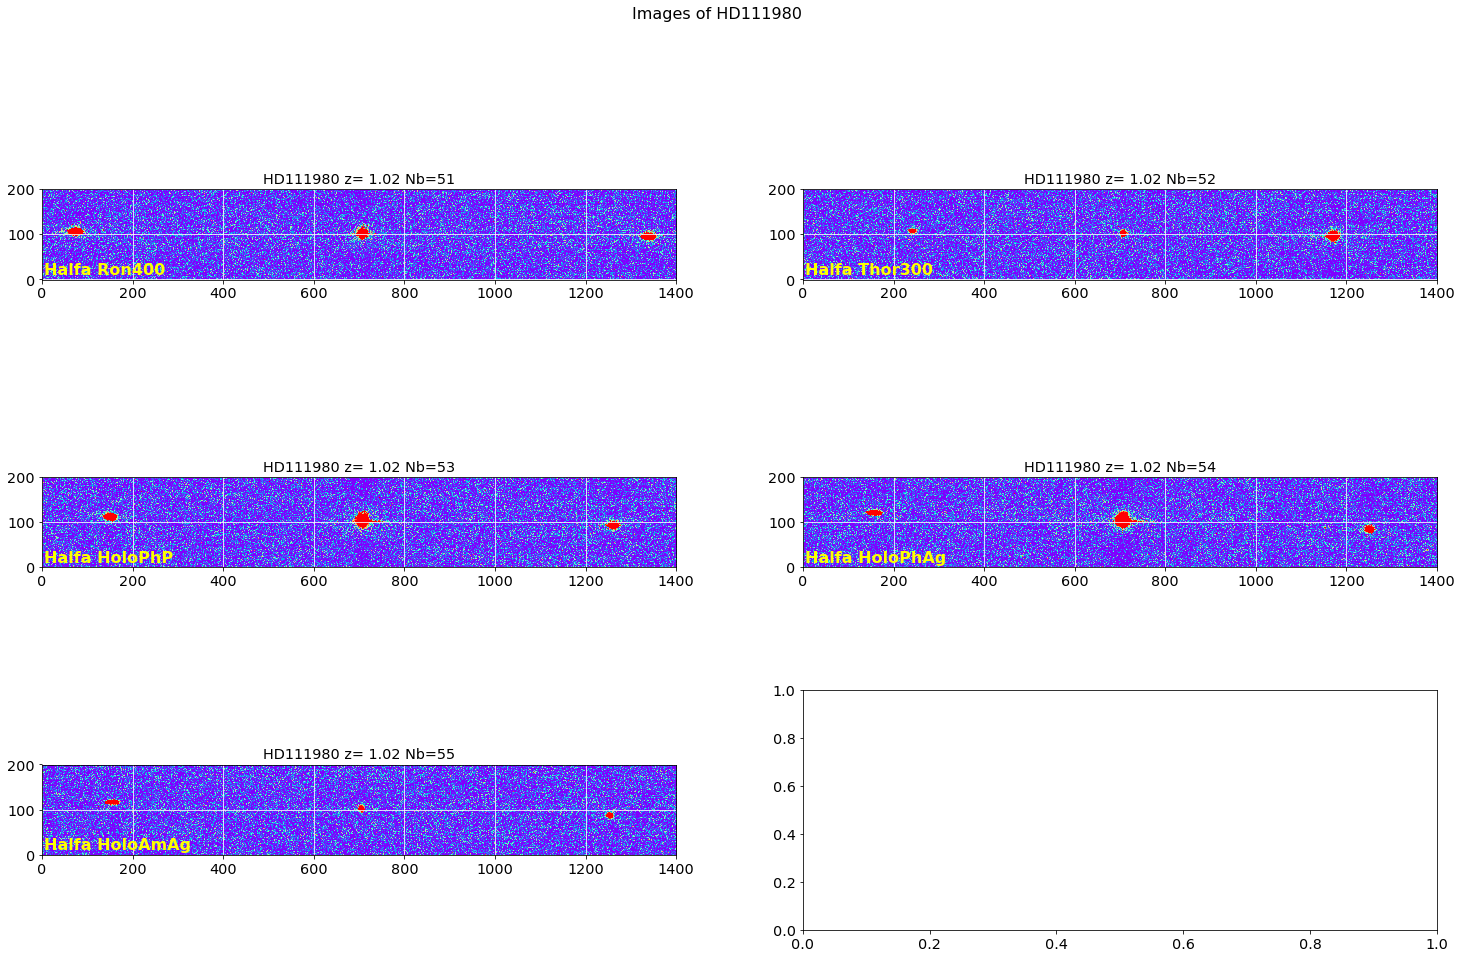

In [15]:
all_images2=[]
for image in all_images:
    image_copy=np.copy(image)
    all_images2.append(image_copy)

for theimage in all_images2:
    NR,NC=theimage.shape
    EmptySkyBackground=np.zeros([NR,NC])
    SkyBackground=EmptySkyBackground+np.median(theimage,axis=0)
    theimage-=SkyBackground
    
ShowImages(all_images2,all_titles,all_filt,object_name,NBIMGPERLROW=2,vmin=0,vmax=20)

## Find rotation by Hessian analysis

La méthode s'inspire des techniques de détection de filmanents dans le milieu interstellaire.
Elle est décrite dans https://arxiv.org/pdf/1409.6728.pdf section 4.1.
Documentation sur le calcul du Hessien : http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.hessian_matrix

### Test rotation optimal settings

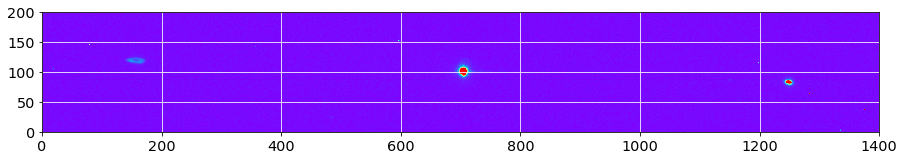

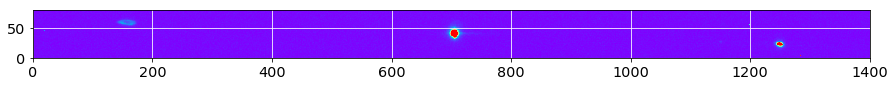

In [16]:
sel=3
image_sel=np.copy(all_images2[sel])
y0=DeltaY[sel]
x0=x_guess[sel]

width_cut = 40
right_edge = 1600

plt.imshow(image_sel,origin='lower',cmap='rainbow',vmin=-10,vmax=800)
plt.grid(color='white', ls='solid')
plt.show()

region=np.copy(image_sel[y0-width_cut:y0+width_cut,0:right_edge])
data=np.copy(region)
plt.imshow(data,origin='lower',cmap='rainbow',vmin=-10,vmax=800)
plt.grid(color='white', ls='solid')
plt.show()

In [17]:
# le paramètre sigma permet de lisser le hessien
Hxx, Hxy, Hyy = hessian_matrix(data, sigma=3, order = 'xy')
lambda_plus = 0.5*( (Hxx+Hyy) + np.sqrt( (Hxx-Hyy)**2 +4*Hxy*Hxy) )
lambda_minus = 0.5*( (Hxx+Hyy) - np.sqrt( (Hxx-Hyy)**2 +4*Hxy*Hxy) )
theta = 0.5*np.arctan2(2*Hxy,Hyy-Hxx)*180/np.pi

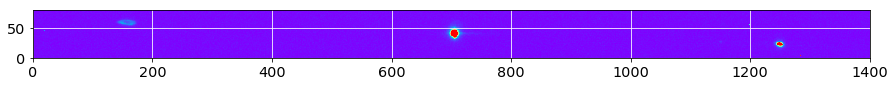

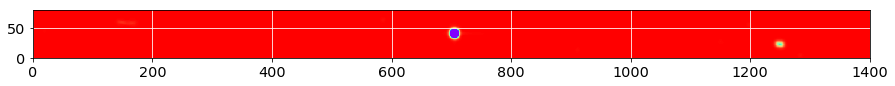

In [18]:
plt.imshow(data,origin='lower',cmap='rainbow',vmin=-10,vmax=800)
plt.grid(color='white', ls='solid')
plt.show()
plt.imshow(lambda_minus,origin='lower',cmap='rainbow',vmin=-100,vmax=0)
plt.grid(color='white', ls='solid')
plt.show()

Number of remaining pixels : 701


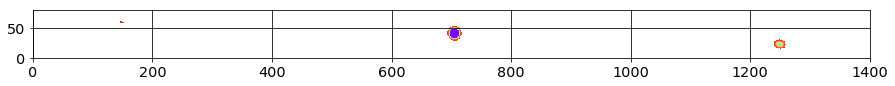

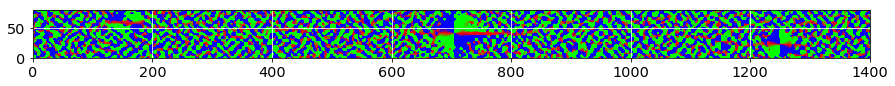

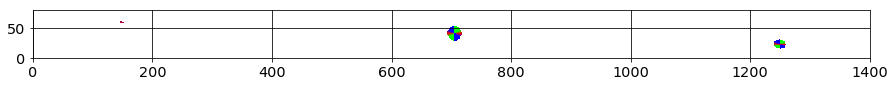

In [19]:
lambda_threshold = -5

mask = np.where(lambda_minus>lambda_threshold)
lambda_mask = np.copy(lambda_minus)
lambda_mask[mask]=np.nan

theta_mask = np.copy(theta)
theta_mask[mask]=np.nan

print 'Number of remaining pixels :',len(lambda_mask[~np.isnan(lambda_mask)])

plt.imshow(lambda_mask,origin='lower',cmap='rainbow',vmin=-100,vmax=0)
plt.grid(color='black', ls='solid')
plt.show()

plt.imshow(theta,origin='lower',cmap=cm.brg,vmin=-30,vmax=30)
plt.grid(color='white', ls='solid')
plt.show()

plt.imshow(theta_mask,origin='lower',cmap=cm.brg,vmin=-30,vmax=30)
plt.grid(color='black', ls='solid')
plt.show()

Number of remaining pixels : 175


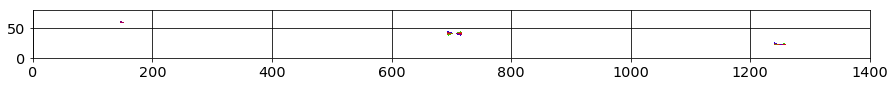

In [20]:
deg_threshold = 20

mask2 = np.where(np.abs(theta)>deg_threshold)
theta_mask[mask2] = np.nan
print 'Number of remaining pixels :',len(theta_mask[~np.isnan(theta_mask)])
plt.imshow(theta_mask,origin='lower',cmap=cm.brg,vmin=-deg_threshold,vmax=deg_threshold)
plt.grid(color='black', ls='solid')
plt.show()

Angle median : -3.20831771983


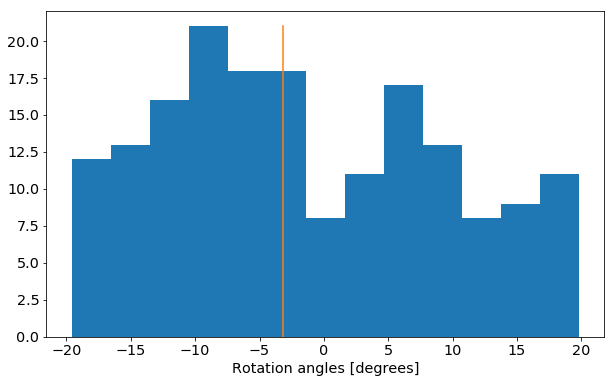

In [21]:
theta_hist = []
theta_hist = theta_mask[~np.isnan(theta_mask)].flatten()
theta_median = np.median(theta_hist)
print 'Angle median :',theta_median
fig = plt.figure(figsize=(10,6))
n,bins, patches = plt.hist(theta_hist,bins=int(np.sqrt(len(theta_hist))))
plt.plot([theta_median,theta_median],[0,np.max(n)])
plt.xlabel("Rotation angles [degrees]")
plt.show()

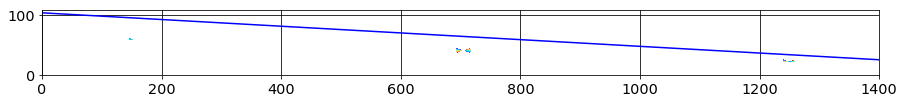

In [22]:
xindex=np.arange(data.shape[1])
x_new = np.linspace(xindex.min(),xindex.max(), 50)
y_new = y0 - width_cut + (x_new-x0)*np.tan(theta_median*np.pi/180.)
plt.imshow(theta_mask,origin='lower',cmap='rainbow',vmin=-deg_threshold,vmax=deg_threshold)
plt.plot(x_new,y_new,'b-')
plt.grid(color='black', ls='solid')
plt.show()

On peut aussi essayer de fitter le spectre qui a été détecté par la méthode ci-dessus.

Rotation angle from fit : -1.89340622329


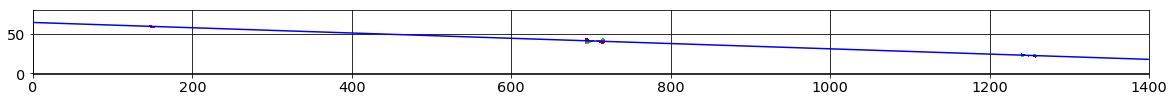

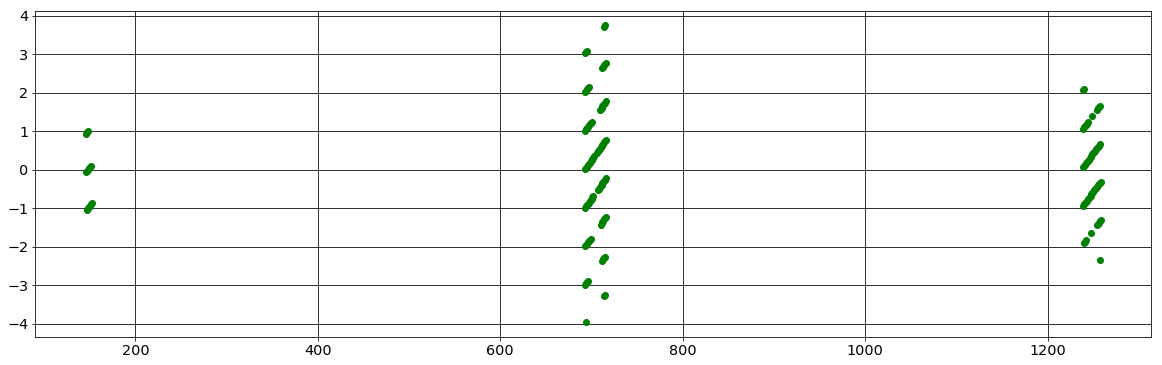

In [23]:
xtofit=[]
ytofit=[]
for iy,y in enumerate(theta_mask):
    for ix,x in enumerate(y):
        if not np.isnan(theta_mask[iy][ix]) :
            if np.abs(theta_mask[iy][ix])>deg_threshold : continue
            xtofit.append(ix)
            ytofit.append(iy)
popt, pcov = fit_line(xtofit, ytofit)
[a, b] = popt
x_new = np.linspace(xindex.min(),xindex.max(), 50)
y_new = line(x_new,a,b)
print 'Rotation angle from fit :',np.arctan(a)*180/np.pi
fig = plt.figure(figsize=[20,6])
plt.imshow(theta_mask,origin='lower',cmap=cm.brg,vmin=-deg_threshold,vmax=deg_threshold)
plt.plot(x_new,y_new,'b-')
plt.grid(color='black', ls='solid')
plt.show()
fig = plt.figure(figsize=[20,6])
diff = []
for ix,x in enumerate(xtofit):
    diff.append(ytofit[ix]-line(x,a,b))
plt.plot(xtofit,diff,'go')
plt.grid(color='black', ls='solid')
plt.show()

0  theta =  -0.466596088761
1  theta =  -0.747273406901
2  theta =  -0.931313848923
3  theta =  -1.89340622329
4  theta =  -1.5008966634


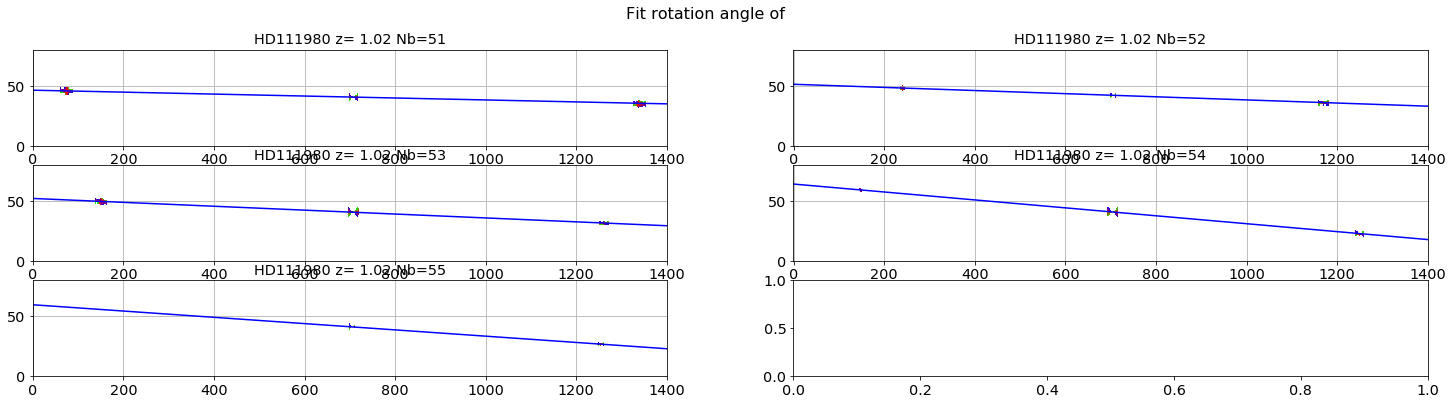

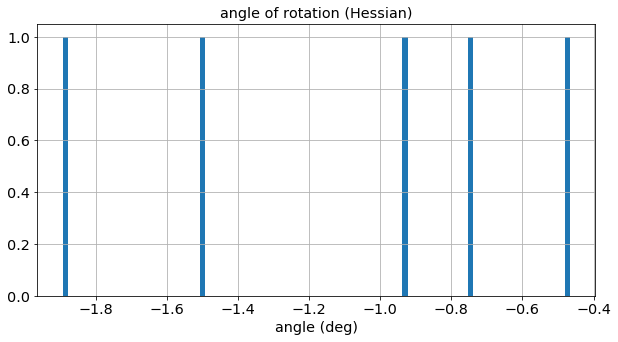

In [24]:
all_theta=ComputeRotationAngleHessianAndFit(all_images2,x_guess,DeltaY,all_titles,object_name, 
            NBIMGPERROW=2, lambda_threshold = -5, deg_threshold = 20, width_cut = 40, right_edge = 1600)
figfilename=os.path.join(dir_top_images,'fit_rotation.pdf')
plt.savefig(figfilename)  

for index in range(len(all_theta)):
    print index,' theta = ',all_theta[index]
plt.figure(figsize=(10,5))
n, bins, patches=plt.hist(all_theta,bins=100,histtype='stepfilled')
plt.grid(True)
plt.title('angle of rotation (Hessian)')
plt.xlabel('angle (deg)')

### Turn the images accordingly

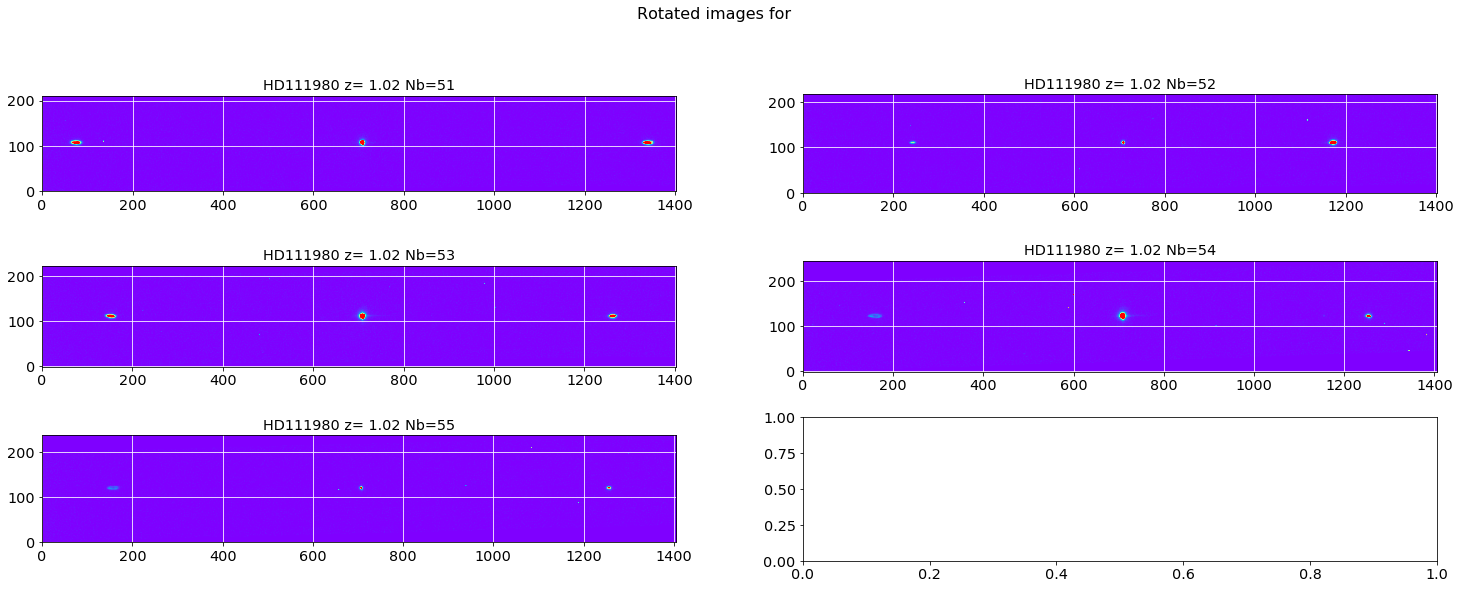

In [25]:
turned_images=TurnTheImages(all_images,all_theta,all_titles,object_name,NBIMGPERROW=2) #same rotation for each image
figfilename=os.path.join(dir_top_images,'rotated_images.pdf')
plt.savefig(figfilename)  

### Check rotation

In case of bad rotation, check by eye

array([-0.01417605, -0.00354897,  0.0087732 ,  0.00482244,  0.00047373])

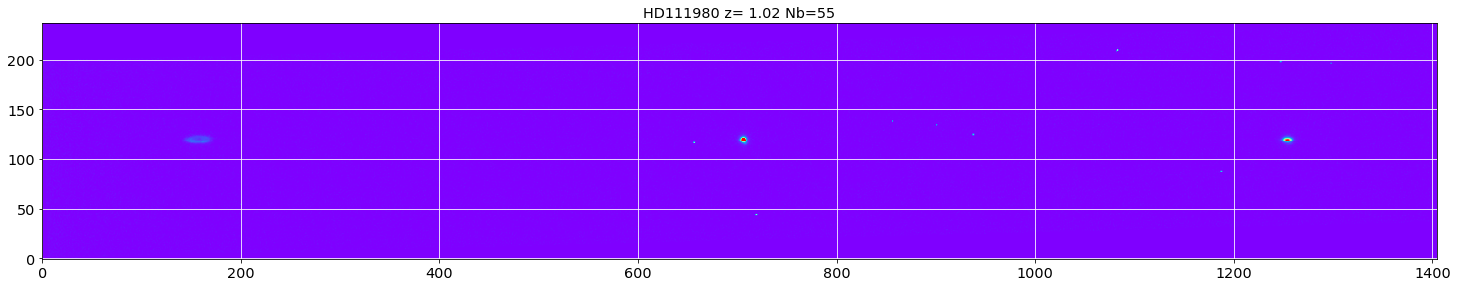

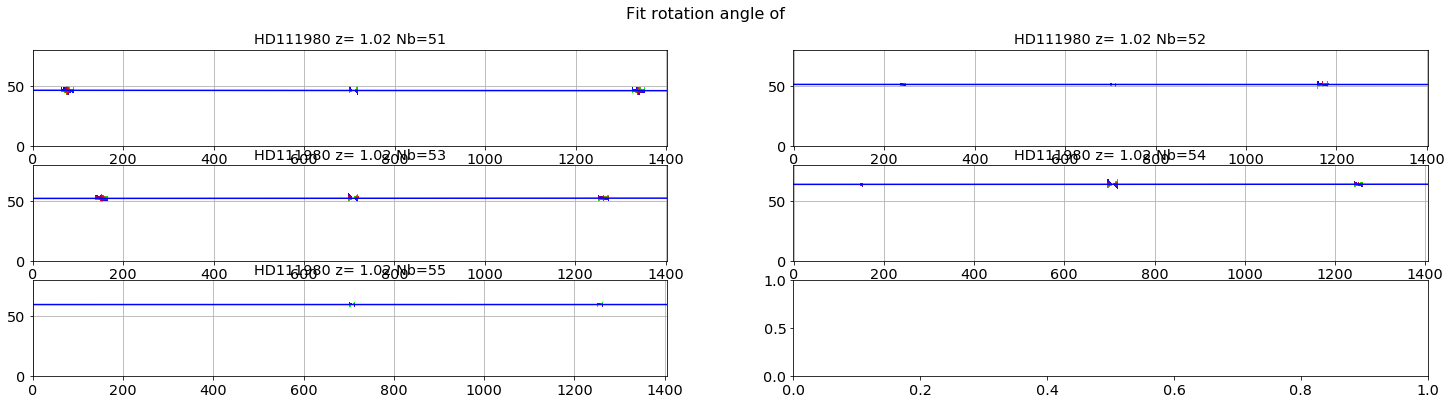

In [26]:
sel=4
plt.figure(figsize=(25,10))
plt.imshow(turned_images[sel],origin='lower',cmap='rainbow',vmin=0,vmax=1000)
plt.grid(True)
plt.title(all_titles[sel])
plt.grid(color='white', ls='solid')
figfilename=os.path.join(dir_top_images,'rotated_image_sample.pdf')
plt.savefig(figfilename)  

ComputeRotationAngleHessianAndFit(turned_images,x_guess,DeltaY,all_titles,object_name, 
            NBIMGPERROW=2, lambda_threshold = -5, deg_threshold = 20, width_cut = 40, right_edge = 1600)

# Find the central star locations
======================================

### Central star positions after rotation

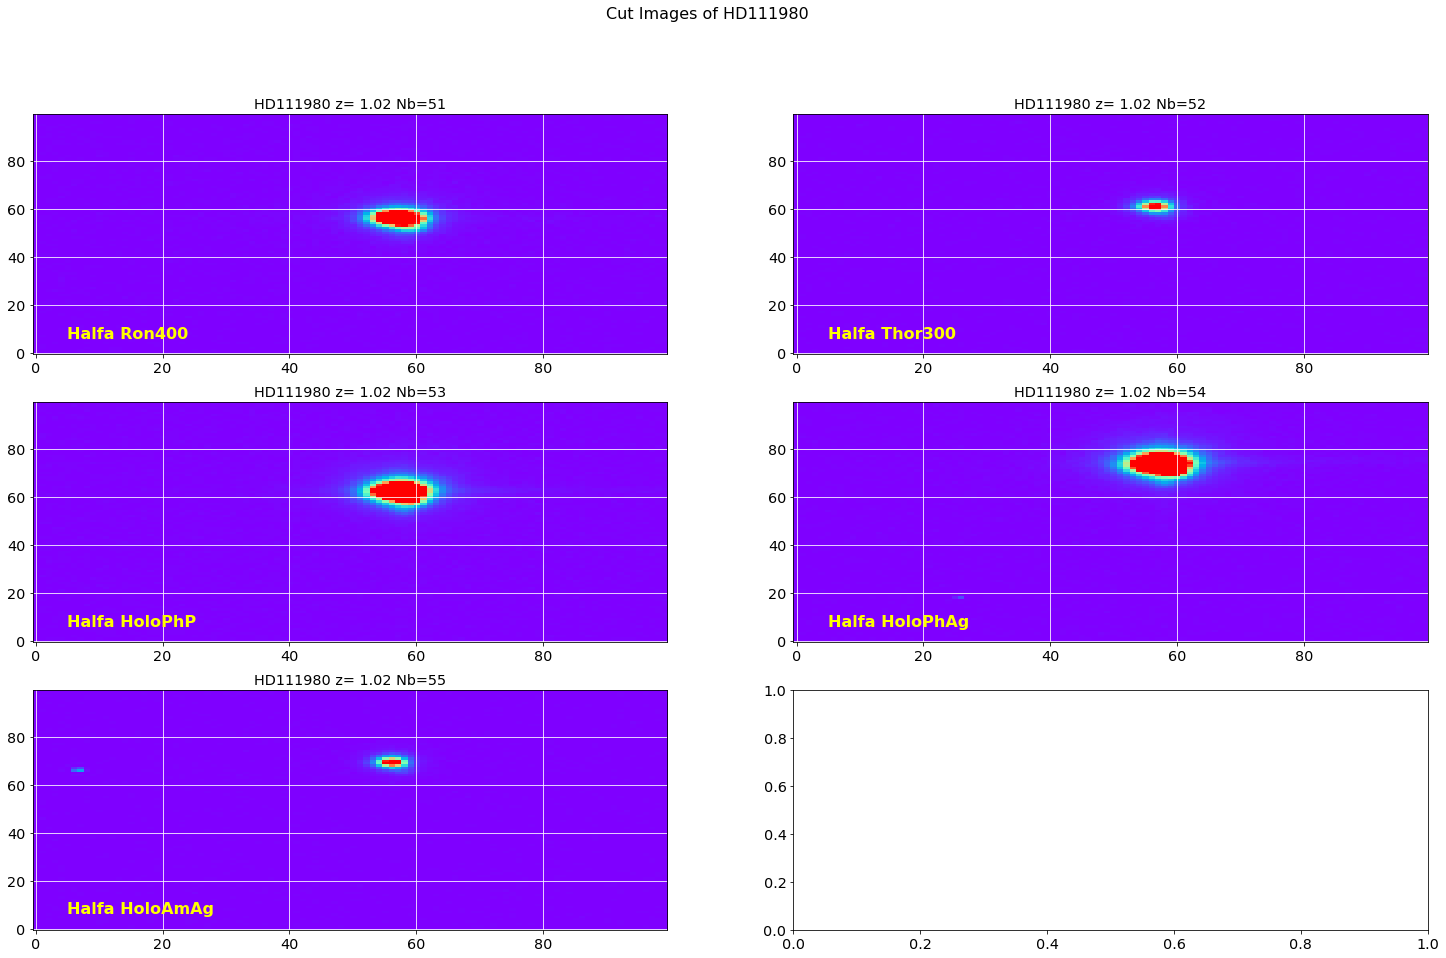

In [27]:
x_guess_rot = DeltaX
y_guess_rot = DeltaY
DeltaY_rot = [50]*len(all_images)
DeltaX_rot = [50]*len(all_images)

images_cut=ShowCenterImages(x_guess_rot,y_guess_rot,DeltaX_rot,DeltaY_rot,
                    turned_images,all_titles,all_filt,object_name,NBIMGPERLROW=2,vmin=0,vmax=2000) 

In [28]:
# (JN) valeurs optimisées pour cette étude
img_mean,img_median,img_std,img_sources=ComputeStatImages(images_cut,fwhm=5,threshold=300,sigma=10.0,iters=5)

----------------------------------------------------------------
0  mean, median, std =  8.00965310019 5.64220352869 15.7925086458
 id   xcentroid     ycentroid   ...      peak          flux          mag      
--- ------------- ------------- ... ------------- ------------- --------------
  1 57.1748056517 56.1178268947 ... 18339.2071614 5.44321368664 -1.83963845985
----------------------------------------------------------------
1  mean, median, std =  3.73134127683 3.41749773639 5.65638837725
 id   xcentroid     ycentroid   ...      peak          flux           mag      
--- ------------- ------------- ... ------------- ------------- ---------------
  1 56.5164010329 60.9593148758 ... 2668.90592583 2.19288714756 -0.852540705443
----------------------------------------------------------------
2  mean, median, std =  14.0985415915 8.2173098025 33.2919336899
 id   xcentroid     ycentroid   ...      peak          flux          mag      
--- ------------- ------------- ... ------------- --

        Use DAOStarFinder instead. [astropy.utils.decorators]


### Central star position

[[ 707.17480565  106.11782689]
 [ 706.51640103  110.95931488]
 [ 707.1778718   112.19857741]
 [ 707.49011242  123.77733155]
 [ 706.07407118  119.39208579]]


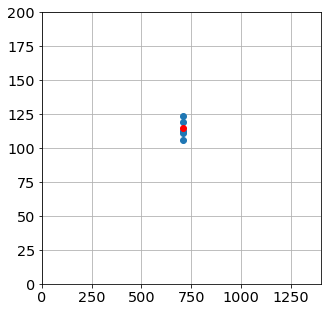

In [29]:
x_star = []
y_star = []
for index,s in enumerate(img_sources):
    for ss in s:
        x_star.append(ss['xcentroid']+x_guess_rot[index]-DeltaX_rot[index])
        y_star.append(ss['ycentroid']+y_guess_rot[index]-DeltaY_rot[index])
        
positions_central = np.array([x_star,y_star]).T
print positions_central

x_mean = np.mean(x_star)
y_mean = np.mean(y_star)
img_size=all_images[0].shape
plt.figure(figsize=(5,5))
plt.plot(x_star,y_star,'o')
plt.plot(x_mean,y_mean,'ro')
plt.xlim(0,img_size[1])
plt.ylim(0,img_size[0])
plt.grid(True)

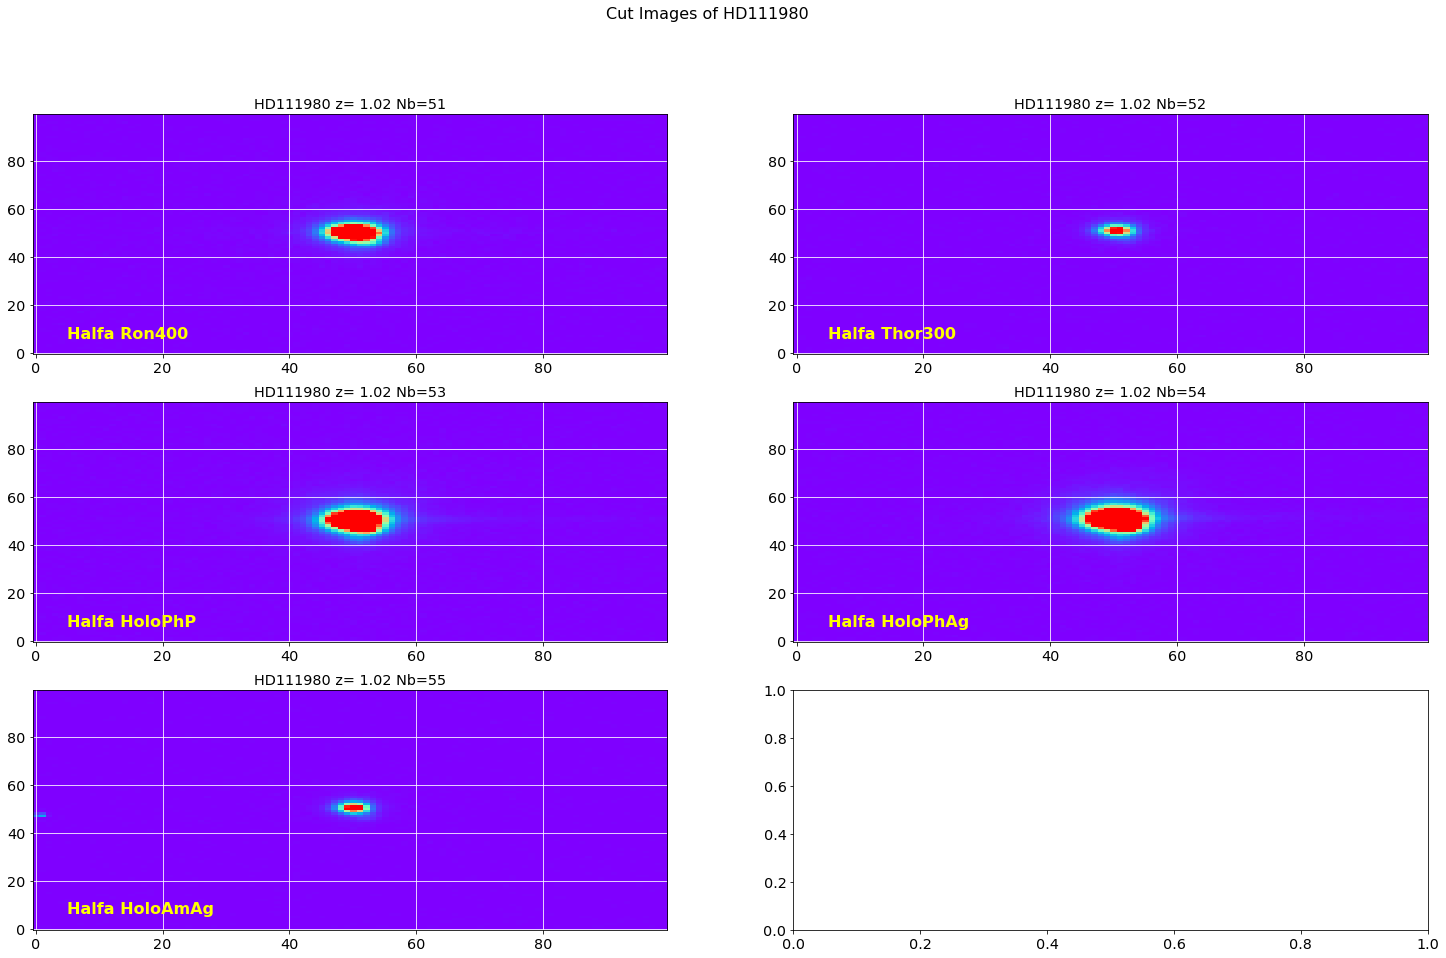

In [30]:
images_cut=ShowCenterImages(x_star,y_star,DeltaX_rot,DeltaY_rot,
                    turned_images,all_titles,all_filt,object_name,NBIMGPERLROW=2,vmin=0,vmax=2000) 

## Save results

In [31]:
newfullfilenames=[]
for idx,f in np.ndenumerate(sorted_files):
    short_infilename=f.split("/")[2]
    short_partfilename=re.findall('^cutimg_(.*)',short_infilename)
    short_outfilename='rotimg_'+short_partfilename[0]
    newfullfilename=os.path.join(outputdir,short_outfilename)
    newfullfilenames.append(newfullfilename)

In [32]:
for idx,f in np.ndenumerate(newfullfilenames):
    prihdu = fits.PrimaryHDU(header=all_header[idx[0]],data=turned_images[idx[0]])
    thdulist = fits.HDUList(prihdu)
    thdulist.writeto(f,overwrite=True)
textfilename=os.path.join(outputdir,'star_centroids.txt')
print textfilename
np.savetxt(textfilename,positions_central,header="y_star x_star",fmt='%d')

!ls -l rotated_fitsimages

./rotated_fitsimages/star_centroids.txt
total 25040
-rw-r--r--  1 jneveu  staff  2378880  7 aoû 14:24 rotimg_20170531_051.fits
-rw-r--r--  1 jneveu  staff  2456640  7 aoû 14:24 rotimg_20170531_052.fits
-rw-r--r--  1 jneveu  staff  2517120  7 aoû 14:24 rotimg_20170531_053.fits
-rw-r--r--  1 jneveu  staff  2779200  7 aoû 14:24 rotimg_20170531_054.fits
-rw-r--r--  1 jneveu  staff  2675520  7 aoû 14:24 rotimg_20170531_055.fits
-rw-r--r--  1 jneveu  staff       56  7 aoû 14:24 star_centroids.txt


# Extract spectra
===================================

In [33]:
outputdir="./spectrum_fitsspec"
ensure_dir(outputdir)

inputdir="./rotated_fitsimages"
SelectTagRe='^rotimg_20170531_([0-9]+).fits$' # regular expression to select the file
SearchTagRe='^rotimg_20170531_[0-9]+.fits$'

In [34]:
sorted_numbers,sorted_files = MakeFileList([inputdir],MIN_IMGNUMBER,MAX_IMGNUMBER,SelectTagRe,SearchTagRe) 

all_dates,all_airmass,all_images,all_titles,all_header,all_expo,all_filt=BuildImages(sorted_files,sorted_numbers,object_name)

print 'Number of images:',len(all_images)

Number of images: 5


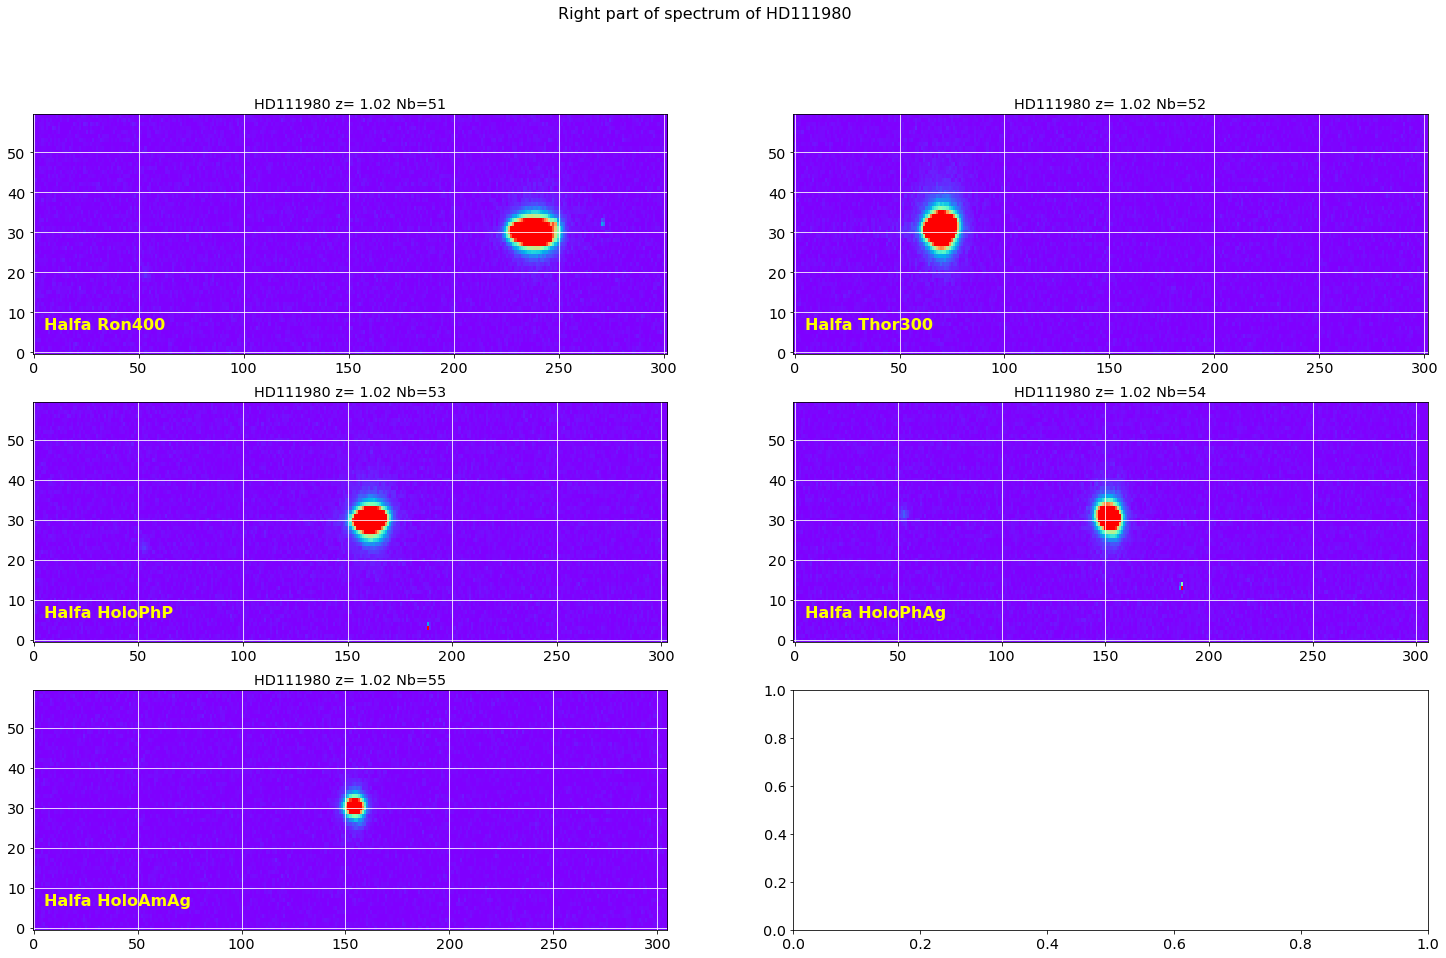

In [35]:
# Right spectrum
ShowCenterImages([1300]*len(all_images),y_star,[200]*len(all_images),[30]*len(all_images),
                 all_images,all_titles,all_filt,object_name,NBIMGPERLROW=2,vmin=0,vmax=500)
title='Right part of spectrum of {} '.format(object_name)
plt.suptitle(title,size=16)
figfilename=os.path.join(dir_top_images,'rightorder.pdf')
plt.savefig(figfilename)  

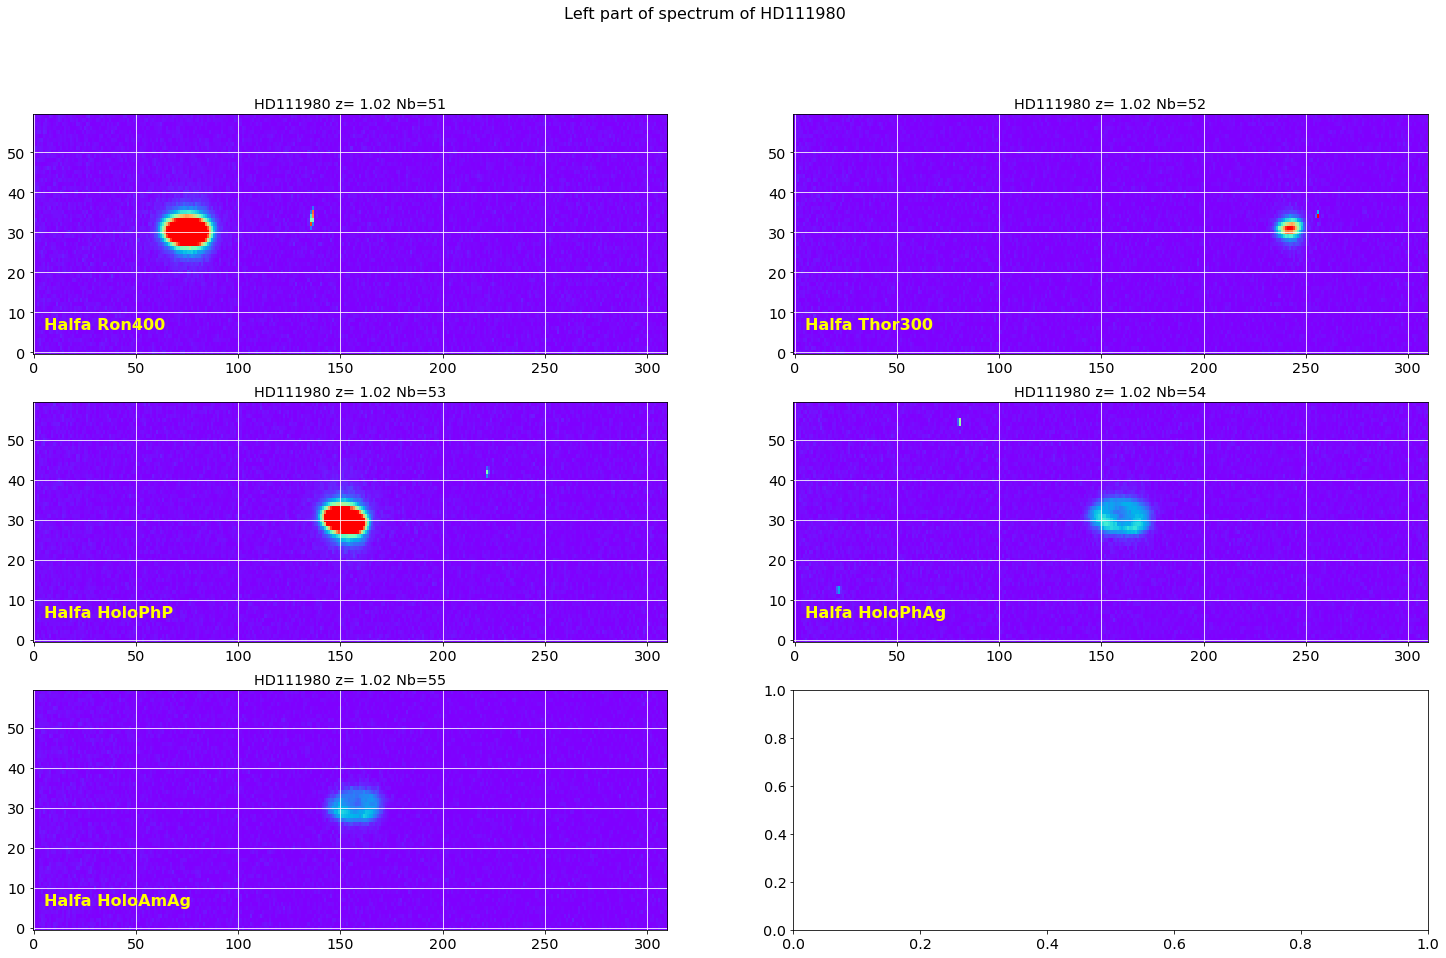

In [36]:
# Left spectrum
ShowCenterImages([110]*len(all_images),y_star,[200]*len(all_images),[30]*len(all_images),
                 all_images,all_titles,all_filt,object_name,NBIMGPERLROW=2,vmin=0,vmax=500)
title='Left part of spectrum of {} '.format(object_name)
plt.suptitle(title,size=16)
figfilename=os.path.join(dir_top_images,'leftorder.pdf')
plt.savefig(figfilename)  

### Extraction

[106, 111, 112, 124, 119]

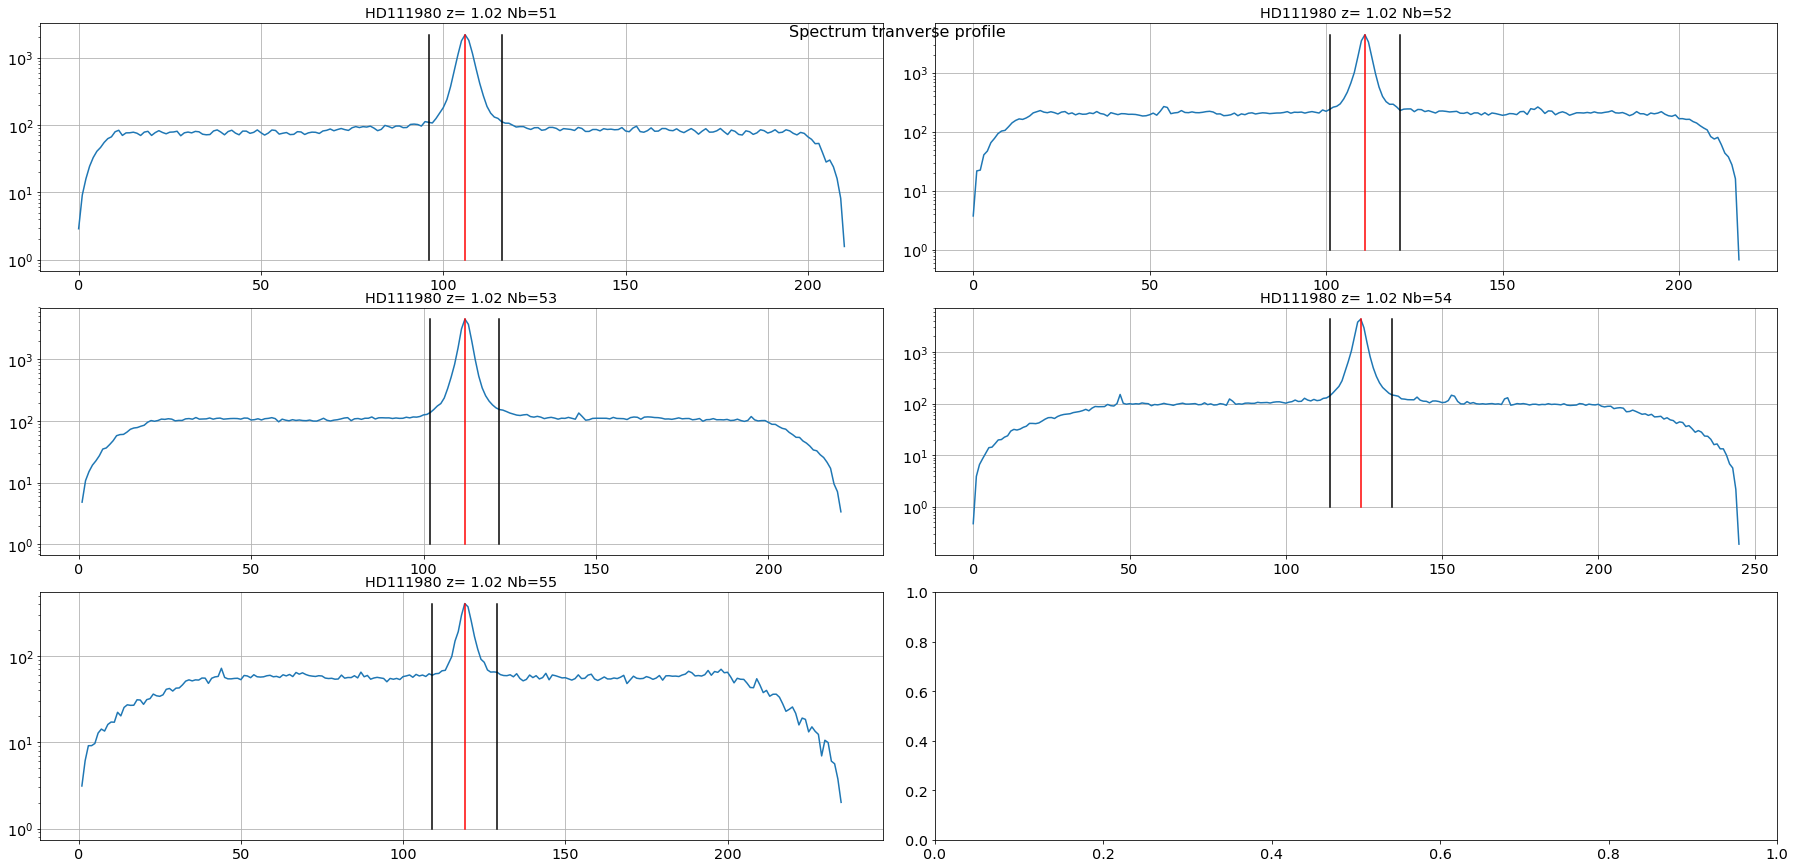

In [37]:
ShowTransverseProfile(all_images,all_titles,object_name,all_expo,NBIMGPERROW=2,DeltaX=1000,w=10,ws=80,right_edge=1800)

In [38]:
thespectra,thespectraUp,thespectraDown=ExtractSpectra(y_star,all_images,all_titles,object_name,all_expo,
                                                      w=10,ws=80,right_edge=1800)

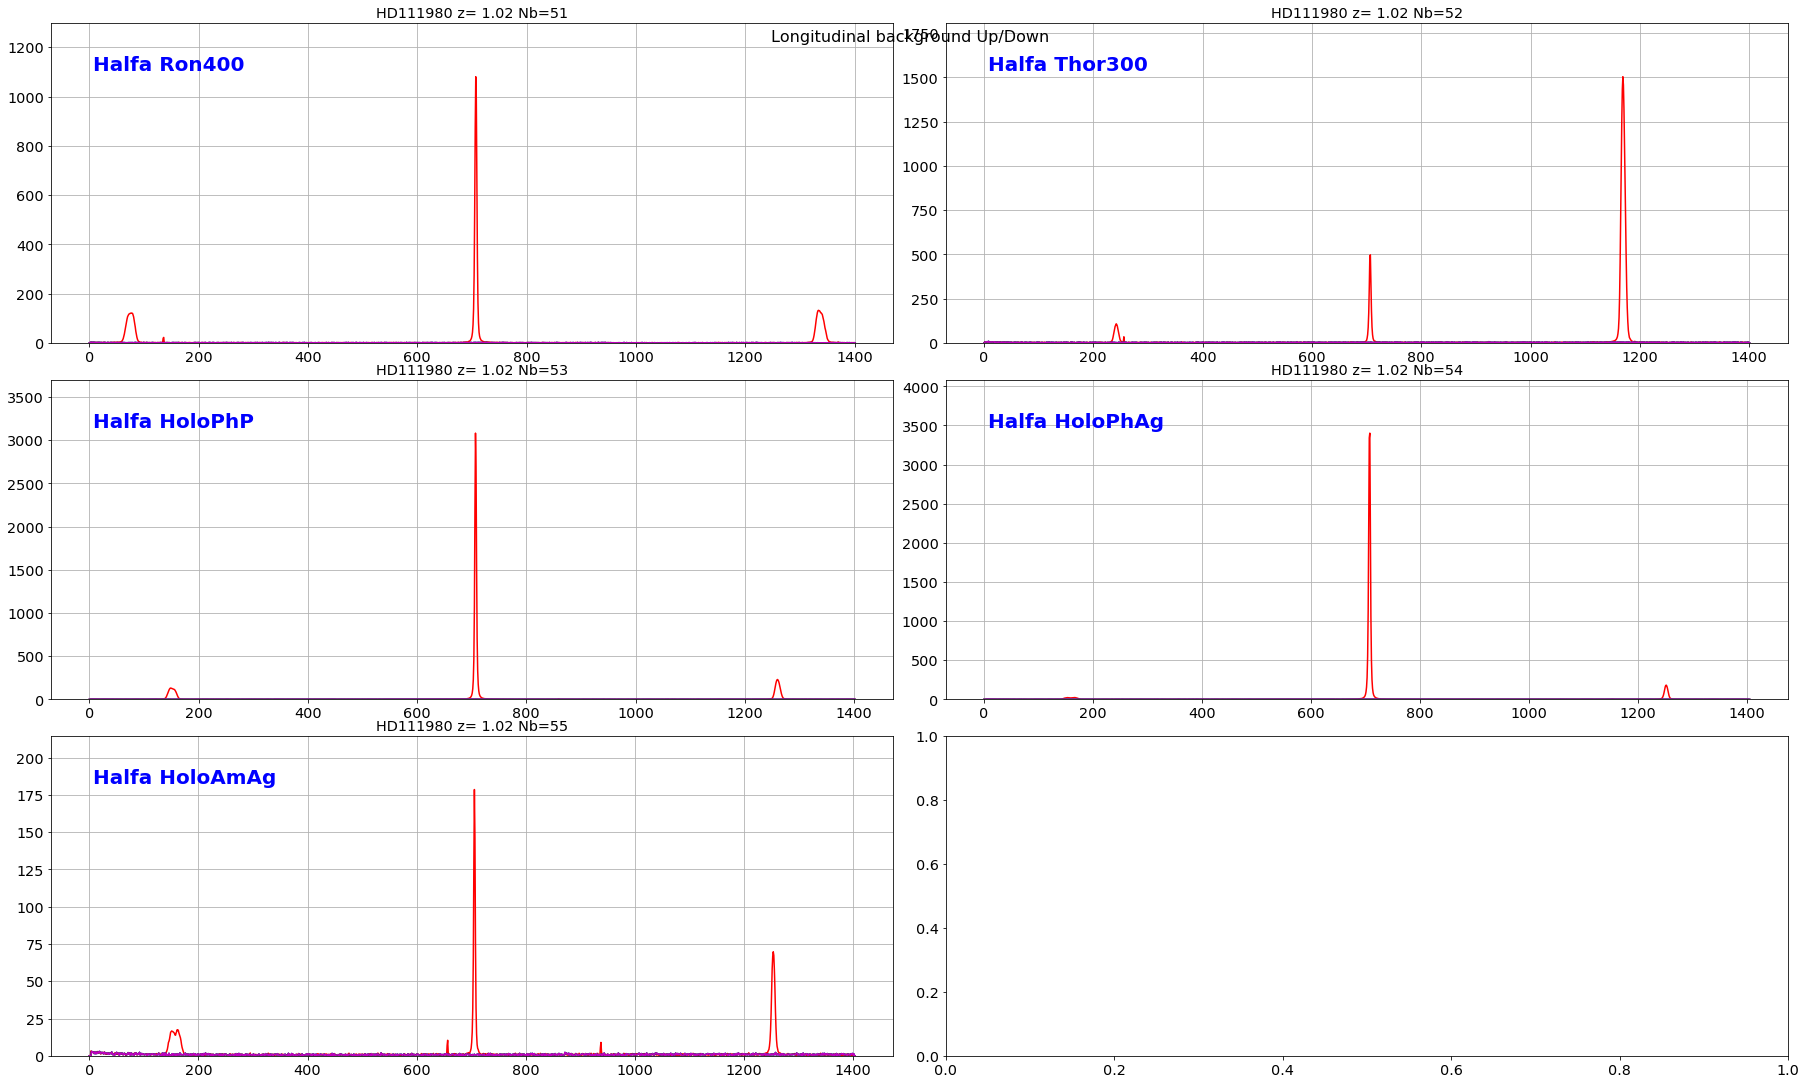

In [39]:
Clean_Up, Clean_Do,Clean_Av=CleanBadPixels(thespectraUp,thespectraDown) 

ShowLongitBackground(thespectra,Clean_Up,Clean_Do,Clean_Av,all_titles,all_filt,object_name,
                     NBIMGPERROW=2,right_edge=1800)
figfilename=os.path.join(dir_top_images,'background_longprofile.pdf')
plt.savefig(figfilename)   

(0, 200.0)

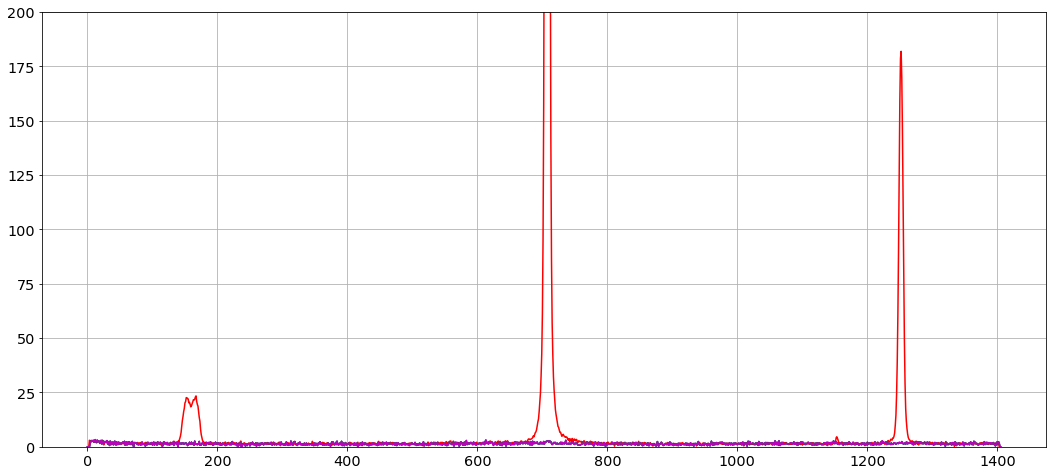

In [40]:
sel=3
plt.figure(figsize=(18,8))
plt.plot(thespectra[sel],'r-') 
plt.plot(Clean_Up[sel],'b-') 
plt.plot(Clean_Do[sel],'g-')
plt.plot(Clean_Av[sel],'m-')
plt.grid(True)
plt.ylim(0,200.)

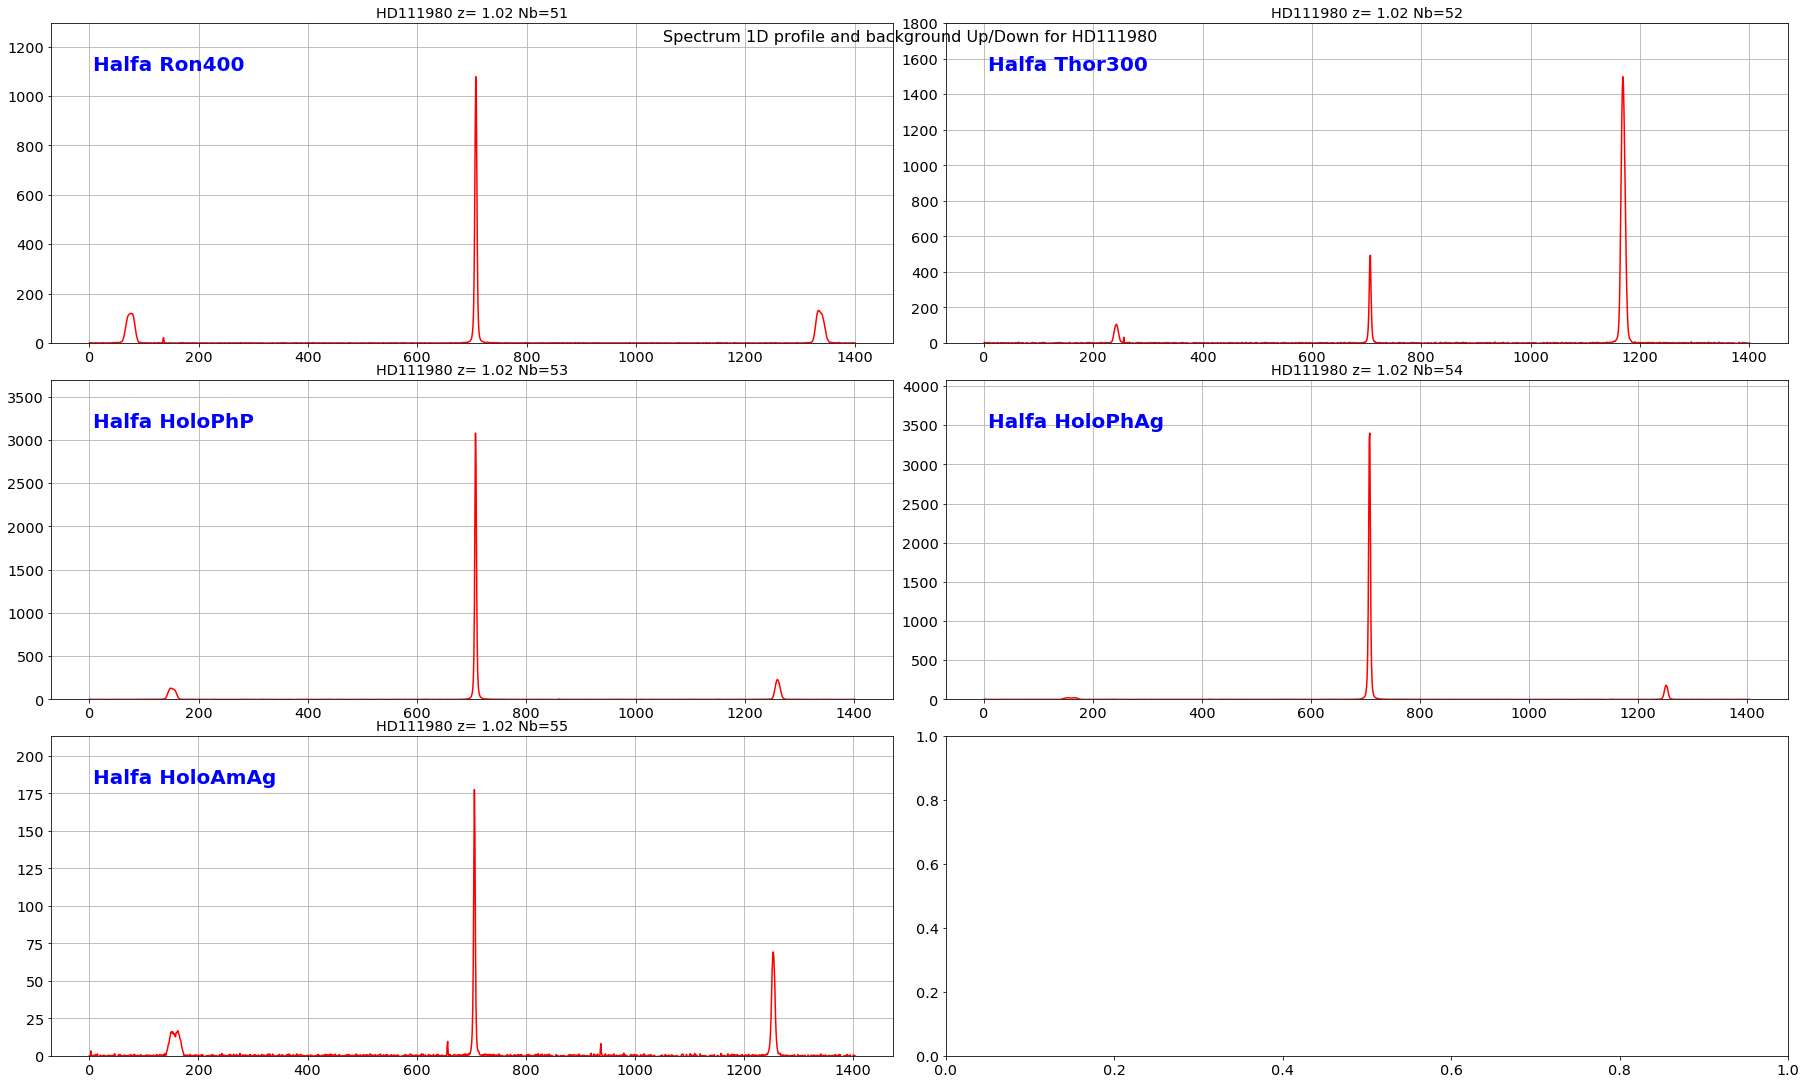

In [41]:
thecorrspectra=CorrectSpectrumFromBackground(thespectra,Clean_Av)

ShowSpectrumProfile(thecorrspectra,all_titles,object_name,all_filt,NBIMGPERROW=2)
figfilename=os.path.join(dir_top_images,'correctedspectrum_profile.pdf')
plt.savefig(figfilename) 

# Grating characterisation

Halfa Ron400:	 gaussian center x=707.19+/-0.03
Halfa Thor300:	 gaussian center x=706.57+/-0.04
Halfa HoloPhP:	 gaussian center x=707.23+/-0.03
Halfa HoloPhAg:	 gaussian center x=707.49+/-0.03
Halfa HoloAmAg:	 gaussian center x=706.09+/-0.03
CCDPROC star centers:
[707.17480565165658, 706.51640103291572, 707.17787180065989, 707.49011241646997, 706.07407118322408]


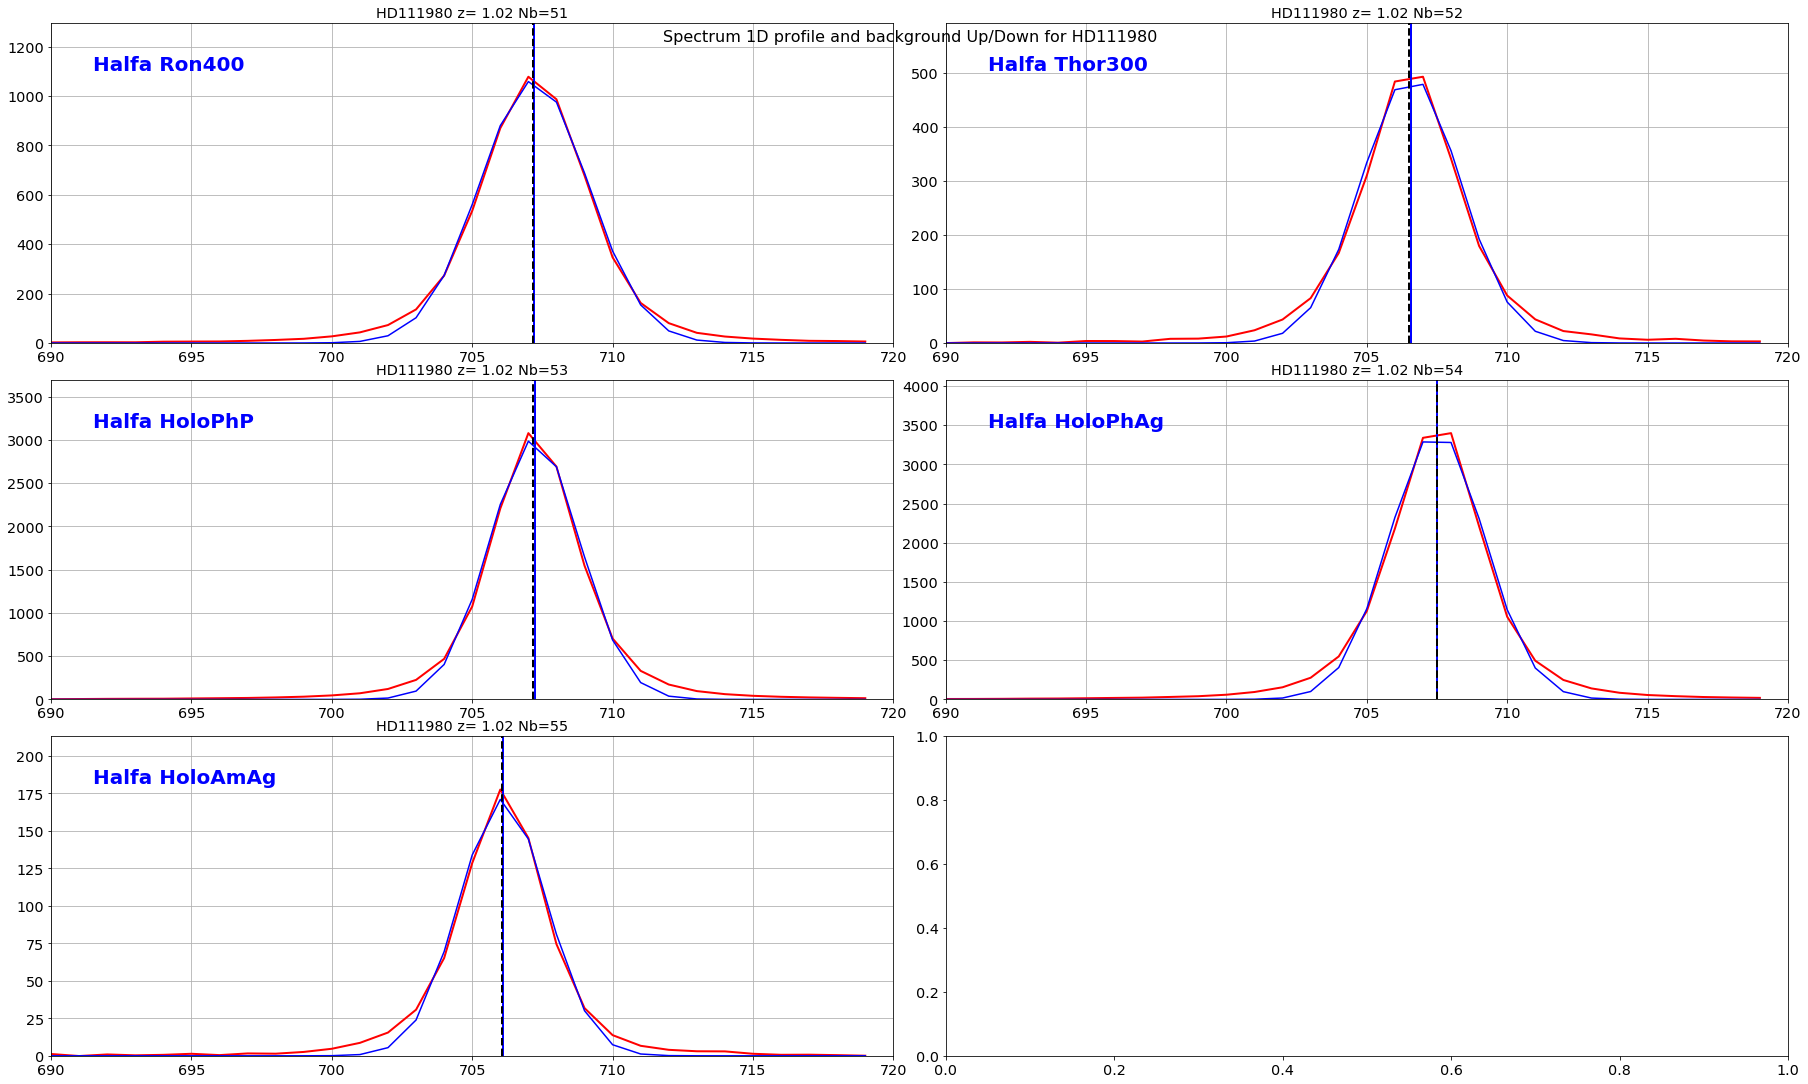

In [42]:
# Zero order profile
ShowSpectrumProfileFit(thecorrspectra,all_titles,object_name,all_filt,NBIMGPERROW=2,
                       xlim=(690,720),guess=[10,700,100],vertical_lines=x_star)
print 'CCDPROC star centers:'
print x_star

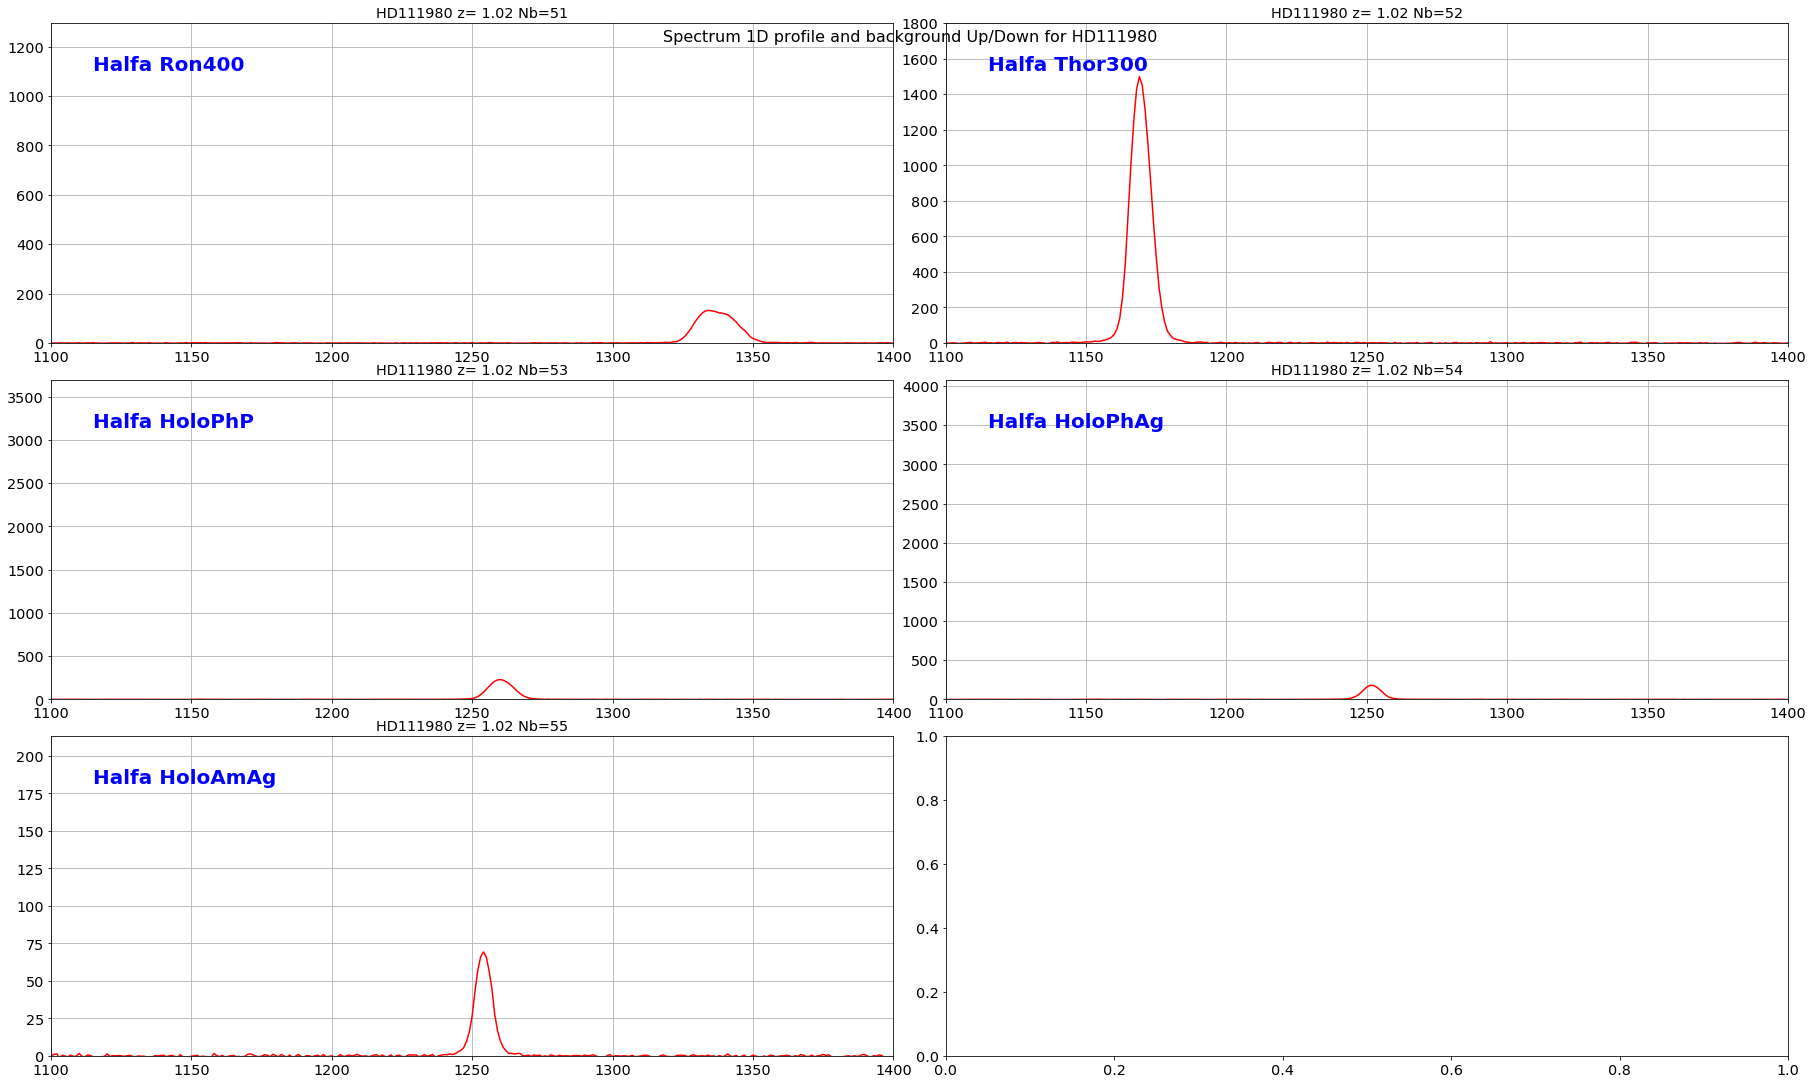

In [43]:
# Right spectrum profile
ShowSpectrumProfile(thecorrspectra,all_titles,object_name,all_filt,NBIMGPERROW=2,xlim=(1100,1400))

Halfa Ron400:	 gaussian center x=1336.75+/-0.06
Halfa Thor300:	 gaussian center x=1169.39+/-0.01
Halfa HoloPhP:	 gaussian center x=1260.16+/-0.01
Halfa HoloPhAg:	 gaussian center x=1251.78+/-0.01
Halfa HoloAmAg:	 gaussian center x=1254.03+/-0.02


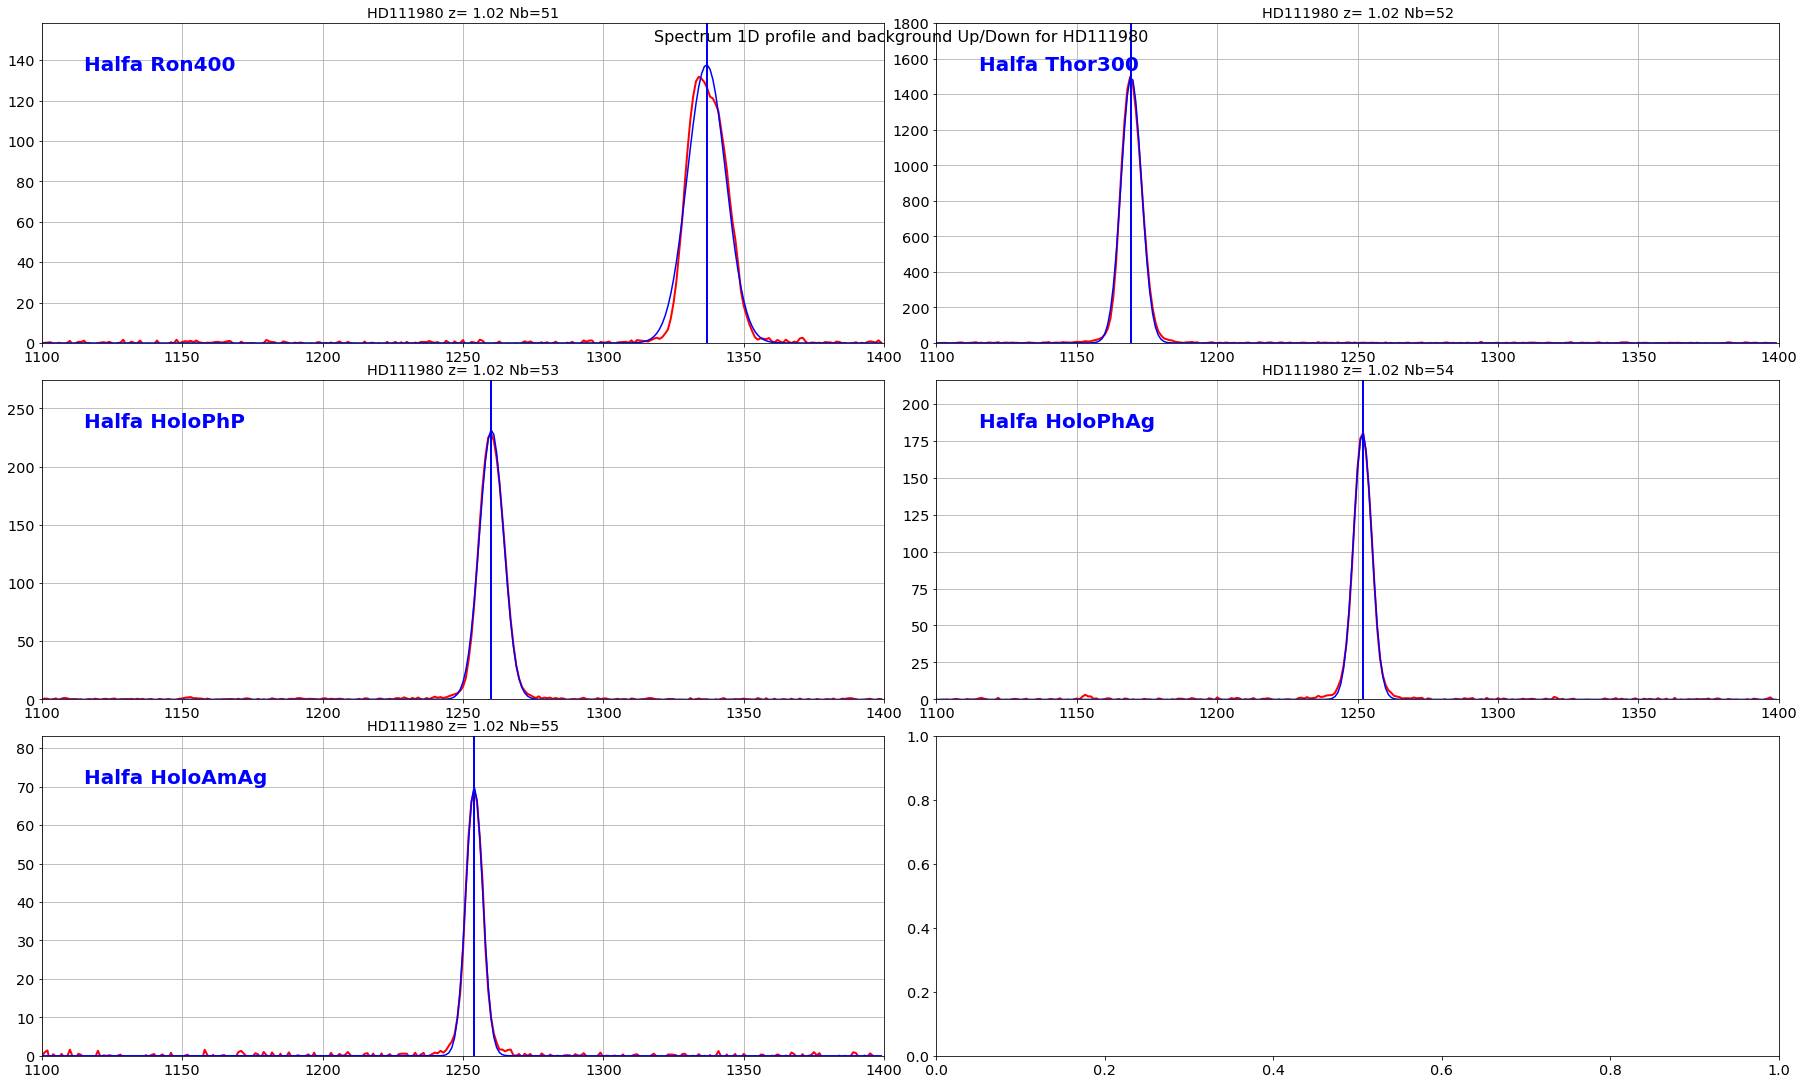

In [44]:
ShowSpectrumProfileFit(thecorrspectra,all_titles,object_name,all_filt,NBIMGPERROW=2,
                            xlim=(1100,1400),guess=[10,1200,200])
figfilename=os.path.join(dir_top_images,'correctedspectrum_rightprofile2.pdf')
plt.savefig(figfilename)  

Halfa Ron400:	 gaussian center x=75.16+/-0.07
Halfa Thor300:	 gaussian center x=242.09+/-0.05
Halfa HoloPhP:	 gaussian center x=151.35+/-0.05
Halfa HoloPhAg:	 gaussian center x=159.46+/-0.20
Halfa HoloAmAg:	 gaussian center x=156.81+/-0.17


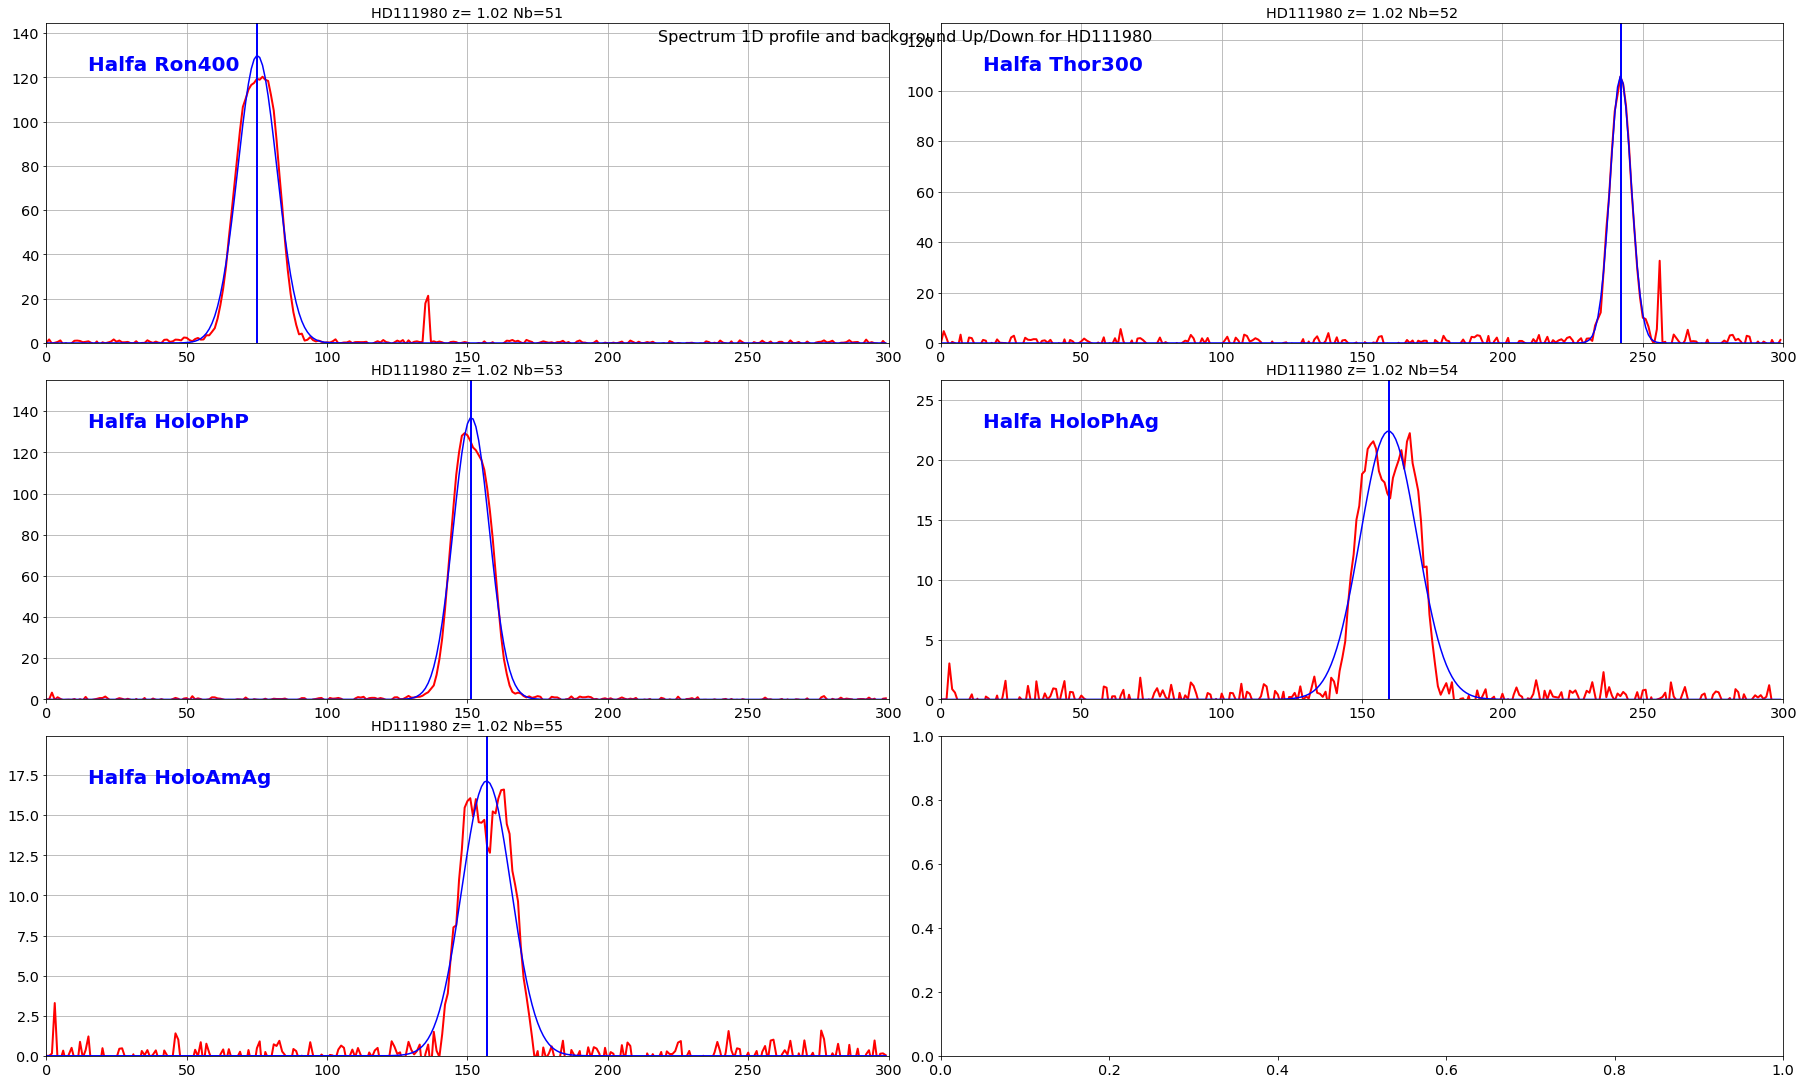

In [45]:
ShowSpectrumProfileFit(thecorrspectra,all_titles,object_name,all_filt,NBIMGPERROW=2,
                            xlim=(0,300),guess=[10,200,100])
figfilename=os.path.join(dir_top_images,'correctedspectrum_leftprofile2.pdf')
plt.savefig(figfilename)  

Present distance to CCD : 55.45 mm (to update if necessary)
-------------------------------
Halfa Ron400
Position of the H-alpha emission line : 629.58 +/- 0.06 pixels (0.01 percent)
Deduced distance to CCD with Halfa Ron400 : 55.58 +/- 0.15 mm (0.27 percent)
-------------------------------
Halfa Thor300
Position of the H-alpha emission line : 462.87 +/- 0.01 pixels (0.00 percent)
Deduced distance to CCD with Halfa Thor300 : 55.36 +/- 0.19 mm (0.35 percent)
-------------------------------
Average distance to CCD : 55.47 +/- 0.17 mm (0.31 percent)


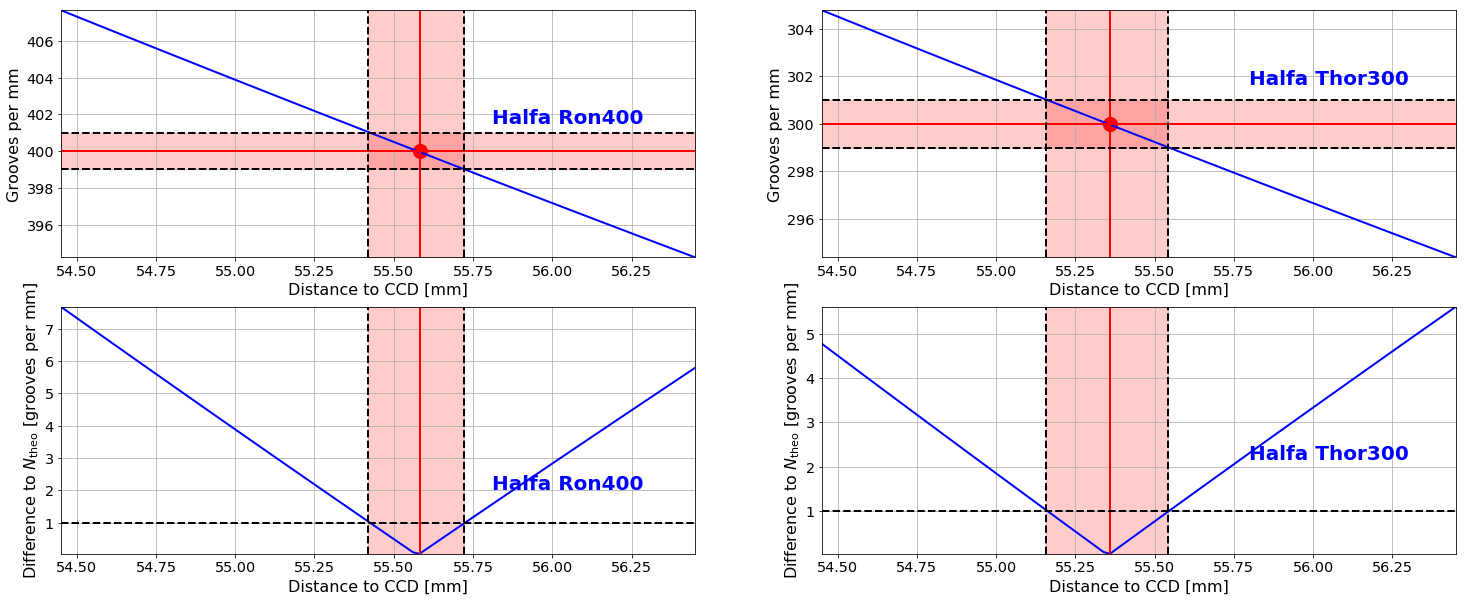

Present distance to CCD : 55.45 mm (to update if necessary)
-------------------------------
Halfa Ron400
Position of the H-alpha emission line : 632.01 +/- 0.07 pixels (0.01 percent)
Deduced distance to CCD with Halfa Ron400 : 55.78 +/- 0.15 mm (0.27 percent)
-------------------------------
Halfa Thor300
Position of the H-alpha emission line : 464.43 +/- 0.05 pixels (0.01 percent)
Deduced distance to CCD with Halfa Thor300 : 55.54 +/- 0.19 mm (0.35 percent)
-------------------------------
Average distance to CCD : 55.66 +/- 0.17 mm (0.31 percent)


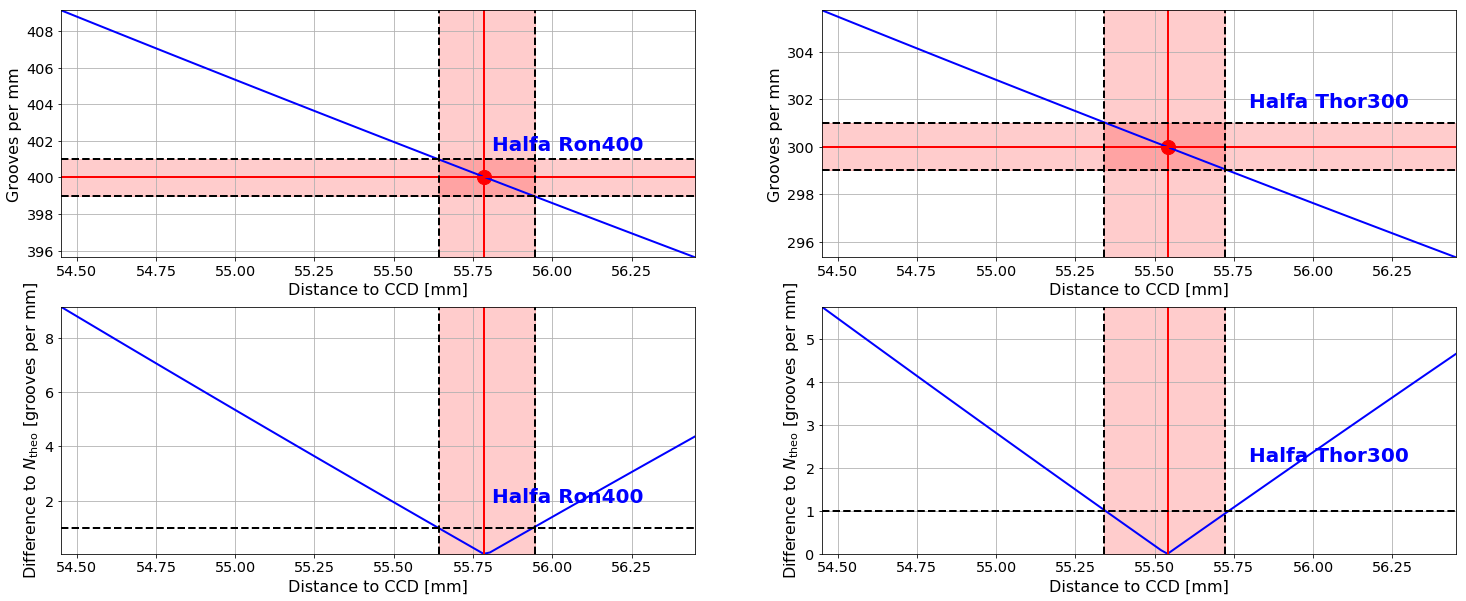

-------------------------------
Average distance to CCD : 55.57 +/- 0.17 mm (0.31 percent)


In [46]:
left_edge = 1100
right_edge = 1400
guess = [10,1200,200]
distance_rightorder, distance_rightorder_err = CalibrateDistance2CCD_OneOrder(thecorrspectra,
                            x_star,all_filt,left_edge,right_edge,guess)

left_edge = 0
right_edge = 300
guess=[10,200,100]
distance_leftorder, distance_leftorder_err = CalibrateDistance2CCD_OneOrder(thecorrspectra,
                            x_star,all_filt,left_edge,right_edge,guess)

print '-------------------------------'  
distance_mean = np.mean([distance_rightorder,distance_leftorder])
distance_mean_err = np.sqrt(np.mean(np.array([distance_rightorder_err,distance_leftorder_err])**2))
print 'Average distance to CCD : %.2f +/- %.2f mm (%.2f percent)' % (distance_mean,distance_mean_err,100*distance_mean_err/distance_mean)

Present distance to CCD : 55.45 mm (to update if necessary)
-------------------------------
Halfa Ron400
Position of the H-alpha emission line : 630.80 +/- 0.04 pixels (0.01 percent)
Deduced distance to CCD with Halfa Ron400 : 55.68 +/- 0.14 mm (0.25 percent)
-------------------------------
Halfa Thor300
Position of the H-alpha emission line : 463.65 +/- 0.03 pixels (0.01 percent)
Deduced distance to CCD with Halfa Thor300 : 55.44 +/- 0.19 mm (0.35 percent)
-------------------------------
Average distance to CCD : 55.56 +/- 0.17 mm (0.30 percent)


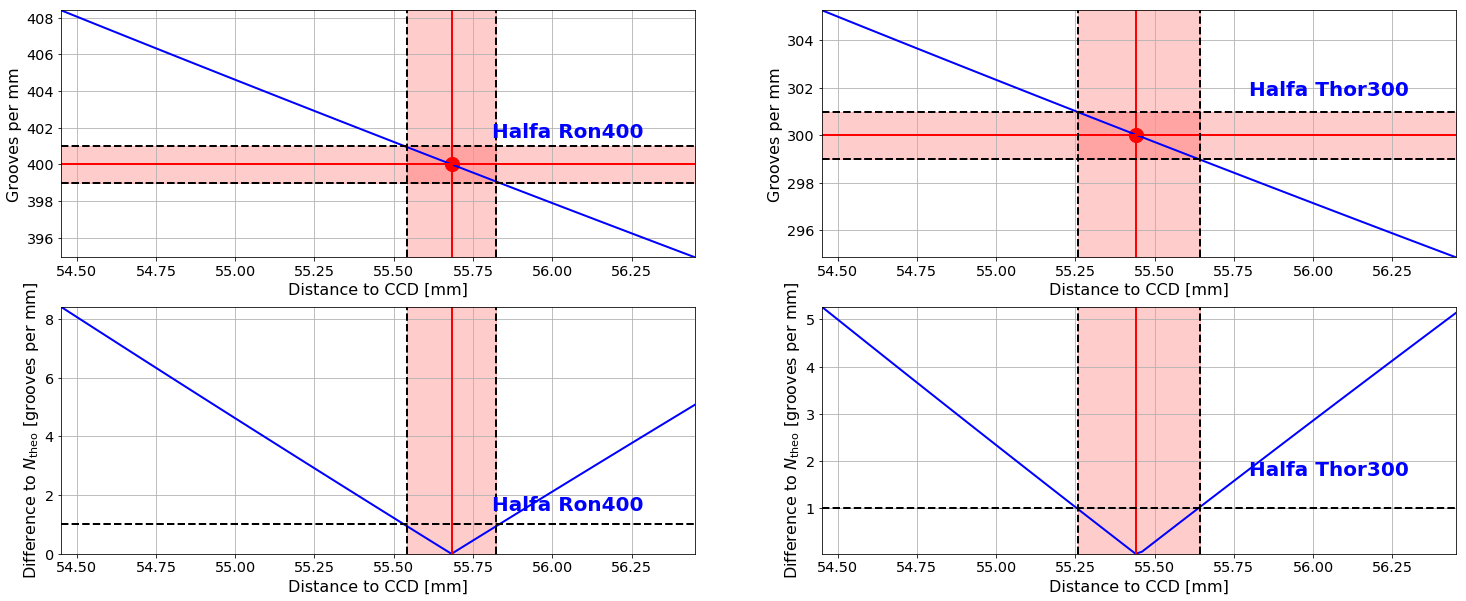

In [47]:
distance_mean, distance_mean_err = CalibrateDistance2CCD_TwoOrder(thecorrspectra,all_filt,
    leftorder_edges=[0,300],rightorder_edges=[1100,1400],guess=[[10,200,200],[10,1200,200]],bounds=(-np.inf,np.inf))

### Conclusion on DISTANCE2CCD

The Thor300 gratings was mounted on the same plastic frame as the holograms, thus the DISTANCE2CCD is expected to closer to the reality for those. The Ron400 H-ampha peaks are unforcused. The Thor300 +1 and -1 orders are well focused then we use the Thor300 TwoOrder method to fix DISTANCE2CCD.

## Resolution of the holograms

With the +1 order

In [48]:
left_edge = 1100
right_edge = 1400
guess = [10,1200,200]
N_rightorder, N_rightorder_err = GratingResolution_OneOrder(thecorrspectra,
                                        x_star,all_images,all_filt,left_edge,right_edge,guess)

H-alpha filter center: 655.9nm 
H-alpha filter width: 6.4nm

Halfa Ron400
N=400.8 +/- 1.3 lines/mm	 H-alpha FWHM=16.1pix with res=0.970nm/pix : FWHM=15.6nm	 ie finesse=71.2
Transverse profile FWHM=5.7pix 
-------------------------------
Halfa Thor300
N=299.5 +/- 1.0 lines/mm	 H-alpha FWHM=8.5pix with res=1.362nm/pix : FWHM=11.6nm	 ie finesse=125.2
Transverse profile FWHM=3.5pix 
-------------------------------
Halfa HoloPhP
N=354.9 +/- 1.2 lines/mm	 H-alpha FWHM=10.2pix with res=1.122nm/pix : FWHM=11.4nm	 ie finesse=130.0
Transverse profile FWHM=3.6pix 
-------------------------------
Halfa HoloPhAg
N=349.6 +/- 1.1 lines/mm	 H-alpha FWHM=7.7pix with res=1.142nm/pix : FWHM=8.7nm	 ie finesse=280.0
Transverse profile FWHM=3.9pix 
-------------------------------
Halfa HoloAmAg
N=351.8 +/- 1.1 lines/mm	 H-alpha FWHM=7.1pix with res=1.133nm/pix : FWHM=8.1nm	 ie finesse=395.6
Transverse profile FWHM=3.6pix 
-------------------------------


With the two orders

In [49]:
Ns, N_errs = GratingResolution_TwoOrder(thecorrspectra,all_images,all_filt,
                        leftorder_edges=[0,300],rightorder_edges=[1100,1400],guess=[[10,200,100],[10,1200,200]])

H-alpha filter center: 655.9nm 
H-alpha filter width: 6.4nm

Halfa Ron400
N=401.6 +/- 1.3 lines/mm
Right order: H-alpha FWHM=16.1pix with res=0.97nm/pix : FWHM=15.6nm	 ie finesse=71.4
Left  order: H-alpha FWHM=16.4pix with res=0.97nm/pix : FWHM=15.9nm	 ie finesse=69.1
Transverse profile FWHM :  5.7pix (right)  6.4pix (left)
-------------------------------
Halfa Thor300
N=300.0 +/- 1.0 lines/mm
Right order: H-alpha FWHM=8.5pix with res=1.4nm/pix : FWHM=11.6nm	 ie finesse=125.7
Left  order: H-alpha FWHM=8.8pix with res=1.4nm/pix : FWHM=12.0nm	 ie finesse=117.3
Transverse profile FWHM :  3.5pix (right)  3.6pix (left)
-------------------------------
Halfa HoloPhP
N=355.7 +/- 1.2 lines/mm
Right order: H-alpha FWHM=10.2pix with res=1.1nm/pix : FWHM=11.4nm	 ie finesse=130.8
Left  order: H-alpha FWHM=15.1pix with res=1.1nm/pix : FWHM=16.9nm	 ie finesse=62.3
Transverse profile FWHM :  3.6pix (right)  5.7pix (left)
-------------------------------
Halfa HoloPhAg
N=350.7 +/- 1.1 lines/mm
Right ord

## Save grating resolutions

The -1 order from the holograms is completely unfocused, thus we use the OneOrder method to set the hologram resolution.

In [50]:
for index in range(len(all_filt)):
    holo_name = all_filt[index].replace('Halfa ','')
    dirname = "../../common_tools/data/"+holo_name
    ensure_dir(dirname)
    print 'Save results in ',dirname
    np.savetxt(dirname+'/N.txt',[N_rightorder[index],N_rightorder_err[index]])

Save results in  ../../common_tools/data/Ron400
Save results in  ../../common_tools/data/Thor300
Save results in  ../../common_tools/data/HoloPhP
Save results in  ../../common_tools/data/HoloPhAg
Save results in  ../../common_tools/data/HoloAmAg


In [51]:
holos = []
for i in range(5):
    print '------------------------------------'
    holos.append(Hologram(all_filt[i].replace('Halfa ','')))

------------------------------------
Grating plate center at x0 = 1024.0 and y0 = 1024.0 with average tilt of -0.3 degrees
N = 400.84 +/- 1.28 grooves/mm
Hologram center at x0 = 741.0 and y0 = 741.0 with average tilt of -0.3 degrees
Plate center at x0 = 774.0 and y0 = 690.7 with average tilt of -0.3 degrees
Order  0 position at x0 = 475.9 and y0 = 742.3
Order +1 position at x0 = 1006.1 and y0 = 739.7
Distance between the orders: 530.15 pixels (12.72 mm)
------------------------------------
Grating plate center at x0 = 1024.0 and y0 = 1024.0 with average tilt of -0.6 degrees
N = 299.49 +/- 0.99 grooves/mm
Hologram center at x0 = 1398.0 and y0 = 1264.0 with average tilt of -0.6 degrees
Plate center at x0 = 774.0 and y0 = 690.7 with average tilt of -0.6 degrees
Order  0 position at x0 = 1132.9 and y0 = 1266.7
Order +1 position at x0 = 1663.1 and y0 = 1261.3
Distance between the orders: 530.15 pixels (12.72 mm)
------------------------------------
Grating plate center at x0 = 1024.0 and y0

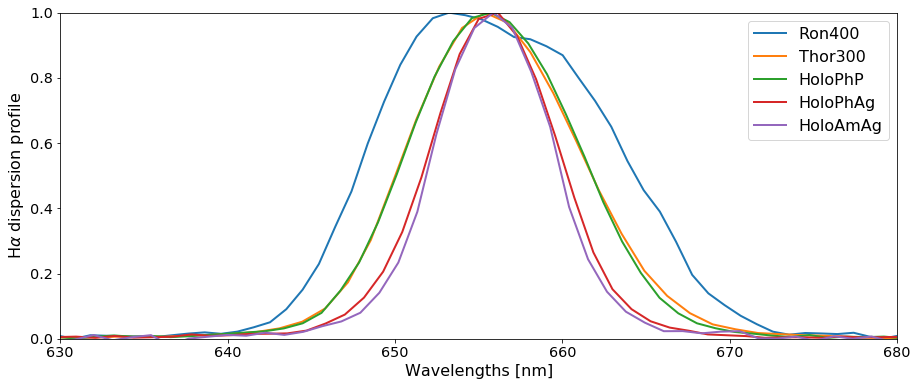

In [54]:
left_edge = 1100
right_edge = 1400

fig, ax = plt.subplots(1,1,figsize=(15,6))
for i in range(5):
    profile = thecorrspectra[i]
    lambdas = holos[i].grating_pixel_to_lambda(np.arange(len(profile)) -x_star[i] ) 
    ax.plot(lambdas,np.array(profile)/np.max(profile[left_edge:right_edge]),label=holos[i].label,lw=2)
#plot_atomic_lines(ax,np.max(profile[1])*1.2,redshift=0,atmospheric_lines=True)
ax.set_xlabel('Wavelengths [nm]',fontsize=16)
ax.set_ylabel('H$\\alpha$ dispersion profile',fontsize=16)
ax.set_ylim([0,1])
ax.set_xlim([630,680])
ax.legend(fontsize=16)
figfilename=os.path.join(dir_top_images,'Halpha_profiles.pdf')
plt.savefig(figfilename, bbox_inches='tight', rasterized=True, dpi=300)  
plt.show()

### Main conclusions

- The distance to CCD has been recalibrated using the two orders from the Thorlabs 300 grating
- The hologram effective grooves per mm number is computed using the right order and is approximately 350+/-1
- FWHMs are better on the +1 order and finesse is better for holograms than gratings. Among holograms HoloPhP is less performant

## Save spectra

In [53]:
newfullfilenames=[]
for idx,file in np.ndenumerate(sorted_files):
    short_infilename=file.split("/")[2]
    short_partfilename=re.findall('^rotimg_(.*)',short_infilename)
    short_outfilename='finalSpectra_'+short_partfilename[0]
    newfullfilename=os.path.join(outputdir,short_outfilename)
    newfullfilenames.append(newfullfilename)

for idx,file in np.ndenumerate(newfullfilenames):
    prihdu = fits.PrimaryHDU(header=all_header[idx[0]],data=thecorrspectra[idx[0]])
    thdulist = fits.HDUList(prihdu)
    thdulist.writeto(file,clobber=True)
    
!ls -l spectrum_fitsspec

total 248
-rw-r--r--  1 jneveu  staff  23040  7 aoû 14:24 finalSpectra_20170531_051.fits
-rw-r--r--  1 jneveu  staff  23040  7 aoû 14:24 finalSpectra_20170531_052.fits
-rw-r--r--  1 jneveu  staff  23040  7 aoû 14:24 finalSpectra_20170531_053.fits
-rw-r--r--  1 jneveu  staff  23040  7 aoû 14:24 finalSpectra_20170531_054.fits
-rw-r--r--  1 jneveu  staff  23040  7 aoû 14:24 finalSpectra_20170531_055.fits
-rw-r--r--  1 jneveu  staff     56  6 aoû 19:52 star_centroids.txt
